# CAS KAGGLE: Anlàlisi de dades d'escacs

https://www.kaggle.com/datasnaek/chess

### Naroa Sarrià 1706167, Inés Gómez 1704361

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, roc_curve,auc,roc_auc_score, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from time import time

%matplotlib inline
sns.set_style('whitegrid')

## 1. EDA (Exploratory Data Analysis)

Carreguem el nostre dataset per veure com son les nostres dades i, posteriorment, veure les dimensions i el tipus de variables.

In [2]:
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
print("Dimensions:", df.shape)
df.info()

Dimensions: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory u

Ara mirem si tenim variables NaN's a les dades

In [4]:
df.isna().mean().sort_values(ascending=False)

id                0.0
rated             0.0
created_at        0.0
last_move_at      0.0
turns             0.0
victory_status    0.0
winner            0.0
increment_code    0.0
white_id          0.0
white_rating      0.0
black_id          0.0
black_rating      0.0
moves             0.0
opening_eco       0.0
opening_name      0.0
opening_ply       0.0
dtype: float64

Com veiem, no tenim missing values a les dades, per tant mirem estadísticament les dades

In [5]:
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


Analitzem ara la nostre variable target, el guanyador de la partida, per veure la seva distribució i per tant per veure també si està balancejada

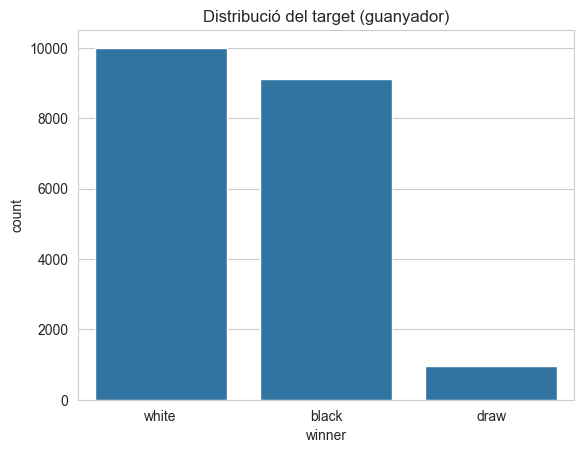

winner
white    0.498604
black    0.454033
draw     0.047363
Name: proportion, dtype: float64

In [6]:
sns.countplot(data=df, x="winner")
plt.title("Distribució del target (guanyador)")
plt.show()

df["winner"].value_counts(normalize=True)

Treiem els empats, ja que són molt pocs (menys del 5%). Per tant, simplificarem els models treient-los de la nostra base de dades i farem classicació binària (white vs black) ja que només ens aportarien soroll i faran molt més complicat entrenar els models de classificació.

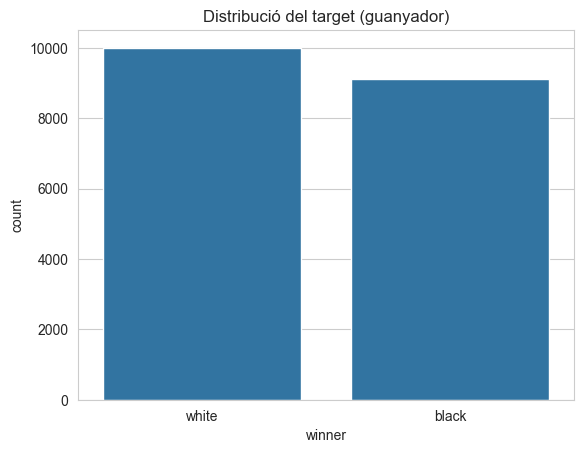

winner
white    0.523393
black    0.476607
Name: proportion, dtype: float64

In [7]:
df = df[df["winner"] != "draw"]
sns.countplot(data=df, x="winner")
plt.title("Distribució del target (guanyador)")
plt.show()

df["winner"].value_counts(normalize=True)

Ara analitzem les variables de ratings, per veure la seva distribució

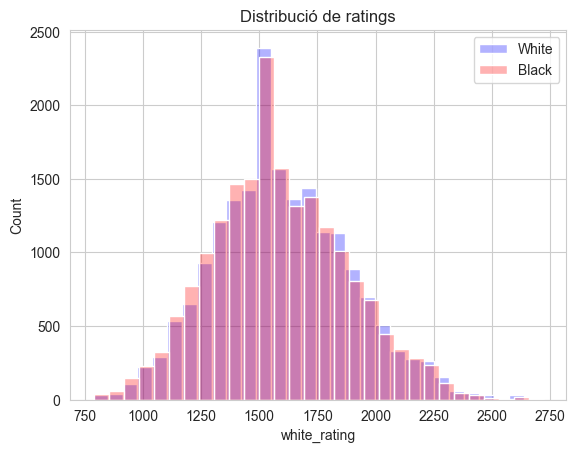

In [8]:
sns.histplot(df["white_rating"], bins=30, color="blue", alpha=0.3, label="White")
sns.histplot(df["black_rating"], bins=30, color="red",  alpha=0.3, label="Black")
plt.title("Distribució de ratings")
plt.legend()
plt.show()

Observem també ràpidament les apertures, per veure quants tipus en tenim i quines son les que mes es repeteixen. Com veiem que hi han masses tipus d'apertures diferents, les agruparem pel tipus d'apertura (no el seu codi propi), les agruparem segons si comencen per A, B, C, D, E (Millor explicat en el següent apartat)

In [9]:
df["opening_name"].value_counts()

opening_name
Van't Kruijs Opening                                                     352
Sicilian Defense                                                         343
Sicilian Defense: Bowdler Attack                                         283
Scotch Game                                                              260
French Defense: Knight Variation                                         256
                                                                        ... 
Italian Game: Scotch Gambit                                                1
English Opening: King's English Variation |  Taimanov Variation            1
Sicilian Defense: Najdorf Variation |  English Attack |  Anti-English      1
Ruy Lopez: Closed Variations |  Pilnik Variation                           1
Dutch Defense: Semi-Leningrad Variation                                    1
Name: count, Length: 1453, dtype: int64

In [10]:
df["opening_eco"].value_counts()

opening_eco
A00    968
C00    806
D00    701
B01    690
C41    663
      ... 
D77      1
C90      1
E35      1
E48      1
D19      1
Name: count, Length: 359, dtype: int64

## Preprocessing + Feature Engineering

Primer codifiquem el nostre target (**winner**) per tenir-lo com a 1 (white) i 0 (black)

In [11]:
df['winner'] = df['winner'].replace({'white': 1, 'black': 0})

C:\Users\nsarr\AppData\Local\Temp\ipykernel_20340\1425917397.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['winner'] = df['winner'].replace({'white': 1, 'black': 0})


Com hem vist a l'apartat anterior, no tenim cap calor NaN a les dades, per tant, ara mirarem si existeixen outliers i com tractar-los.

Començarem analitzant si es poden detectar outliers en la variable "turns".

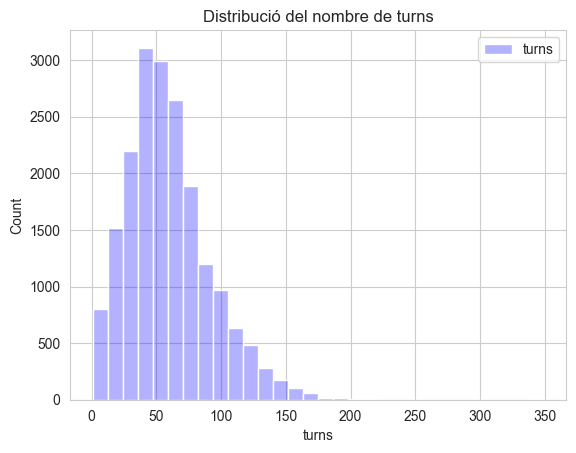

In [12]:
sns.histplot(df["turns"], bins=30, color="blue", alpha=0.3, label="turns")
plt.title("Distribució del nombre de turns")
plt.legend()
plt.show()


In [13]:
df["turns"].describe()

count    19108.000000
mean        59.188664
std         32.310010
min          1.000000
25%         37.000000
50%         54.000000
75%         77.000000
max        349.000000
Name: turns, dtype: float64

El nombre mínim de turns que es necessiten per poder guanyar una partida és 4, de manera que mirarem quantes partides tenim que tenen un nombre inferior a aquest i, seguidament, les eliminarem, ja que són partides que no ens aporten informació útil.

In [14]:
valor = (df["turns"] < 4).sum()
print("Nombre de partides amb un nombre de turns menor a 4:",valor)

Nombre de partides amb un nombre de turns menor a 4: 277


Com només són 277 partides, ens podem permetre treure aquestes del nostre dataset, per tal d'evitar que valors inconsistents ens afectin el nostre model. 

In [15]:
df = df[df["turns"] >= 4]
valor = (df["turns"] < 4).sum()
print("Comprovem que ara hi ha",valor,"partides amb menys de 4 moviments.")

Comprovem que ara hi ha 0 partides amb menys de 4 moviments.


Mirem ara valors massa elevats. Una partida amb més de 200 moviments són casos molt extrems, que no passen gairebé mai, per tant, podem mirar quants casos tenim i, si són pocs, els podrem eliminar, ja que no representen bé les nostres dades.

In [16]:
valor = (df["turns"] > 200 ).sum()
print("Tenim",valor,"partides amb més de 200 moviments.")

Tenim 11 partides amb més de 200 moviments.


In [17]:
#Com només són 11 partides, les podem eliminar.
df = df[df["turns"] <= 200]
valor = (df["turns"] > 200 ).sum()
print("Tenim",valor,"partides amb més de 200 moviments.")

Tenim 0 partides amb més de 200 moviments.


A continuació, començarem a tractar i a fer feature engineering amb les variables conegudes prèvies a començar la partida.

Comencem per tant creant la variable **diff_rating** que serà la diferència entre els ratings dels dos jugadors (white_rating - black_rating)

In [18]:
df["diff_rating"] = df["white_rating"] - df["black_rating"]

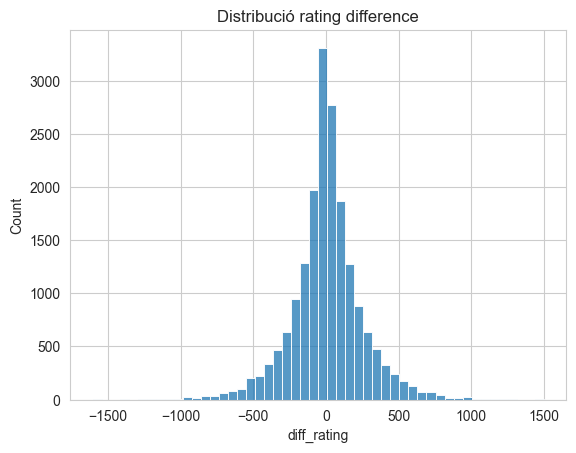

In [19]:
sns.histplot(df["diff_rating"], bins=50)
plt.title("Distribució rating difference")
plt.show()

Ara farem variables que vagin acumulant el winrate global dels dos jugadors que s'enfrenten en cada partida fins aquell moment. Aquesta variable es calcularà com: $$\text{winrate} = \frac{\text{partides guanyades fins al moment}}{\text{partides totals jugades}}$$

Per fer aquestes variables, i les que farem a continuació, hem d'ordenar primerament les partides cronològicament

In [20]:
# Asegurar que la fecha esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Ordenar por fecha
df = df.sort_values('created_at')

In [21]:
winning = {}

# Nuevas listas para almacenar variables explicativas
white_global_winrate = []
black_global_winrate = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]  # 1 = white, 0 = black

    # Inicializar historial si no existe
    if white not in winning:
        winning[white] = { "total_matches" : 0, "wins" : 0}
    
    if black not in winning:
        winning[black] = { "total_matches" : 0, "wins" : 0}

    #Calcular el winrate que porten
    if (winning[white]["total_matches"] > 0):
        rate = winning[white]["wins"] / winning[white]["total_matches"]
        white_global_winrate.append(rate)
    else:
        white_global_winrate.append(0)


    if (winning[black]["total_matches"] > 0):
        rate = winning[black]["wins"] / winning[black]["total_matches"]
        black_global_winrate.append(rate)
    else:
        black_global_winrate.append(0)

    
    #Afegir la partida actual
    winning[white]["total_matches"] += 1
    if(winner == 1):
        winning[white]["wins"] += 1

    winning[black]["total_matches"] += 1
    if(winner == 0):
        winning[black]["wins"] += 1


# Añadir nuevas columnas al DataFrame
df["white_global_winrate"] = white_global_winrate
df["black_global_winrate"] = black_global_winrate

Ara fem les següents noves variables explicatives per a cada parella de jugadors que s'enfrenten:
* **vs_white_winrate**: es un percentatge de victòries prèvies del jugador que juga amb blanques contra aquell mateix rival abans de la partida actual. Cal esmentar que els empats compten com 0,5.
* **vs_prev_matches**: Nombre total de partides que els dos jugadors havien jugat prèviament entre ells (sense importar colors ni resultats).
* **vs_played_before**: Variable binària que és 0 si els jugadors no s’havien enfrontat mai i val 1 si la parella sí havien jugat junts abans.

In [22]:

history = {}

# Nuevas listas para almacenar variables explicativas
vs_white_winrate = []
vs_prev_matches = []
vs_played_before = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"] 

    # Crear key ordenada para la pareja
    pair = tuple(sorted([white, black]))

    # Inicializar historial si no existe
    if pair not in history:
        history[pair] = {
            "white_wins_player1": 0,
            "white_wins_player2": 0,
            "total_matches": 0
        }
        # Nunca se habían enfrentado antes
        vs_white_winrate.append(0.0)
        vs_prev_matches.append(0)
        vs_played_before.append(0)
    else:
        # Recuperar historial previo
        p1, p2 = pair

        # Determinar cuántas veces ganó el blanco antes
        if white == p1:
            prev_white_wins = history[pair]["white_wins_player1"]
        else:
            prev_white_wins = history[pair]["white_wins_player2"]

        prev_total = history[pair]["total_matches"]

        # Calcular winning rate del blanco
        rate = prev_white_wins / prev_total if prev_total > 0 else 0.0
        
        vs_white_winrate.append(rate)
        vs_prev_matches.append(prev_total)
        vs_played_before.append(1)

    # Actualizar historial *después* de registrar datos previos
    if winner == 1:  # blanco gana
        if white == pair[0]:
            history[pair]["white_wins_player1"] += 1
        else:
            history[pair]["white_wins_player2"] += 1
            
    # Siempre aumentar el total de partidas entre ellos
    history[pair]["total_matches"] += 1

# Añadir nuevas columnas al DataFrame
df["vs_white_winrate"] = vs_white_winrate
df["vs_prev_matches"] = vs_prev_matches
#df["vs_played_before"] = vs_played_before


In [23]:
df["vs_white_winrate"].value_counts()

vs_white_winrate
0.000000    17744
1.000000      535
0.500000      211
0.333333      107
0.250000       29
0.400000       26
0.666667       23
0.200000       14
0.600000       14
0.166667       13
0.428571       12
0.142857        9
0.750000        8
0.285714        5
0.571429        4
0.444444        4
0.555556        4
0.222222        4
0.583333        3
0.714286        3
0.636364        2
0.153846        2
0.454545        2
0.384615        2
0.176471        2
0.466667        2
0.300000        2
0.375000        2
0.125000        2
0.238095        2
0.260870        2
0.416667        1
0.052632        1
0.550000        1
0.562500        1
0.100000        1
0.181818        1
0.357143        1
0.318182        1
0.315789        1
0.187500        1
0.350000        1
0.111111        1
0.090909        1
0.133333        1
0.437500        1
0.388889        1
0.210526        1
0.363636        1
0.470588        1
0.473684        1
0.476190        1
0.478261        1
0.360000        1
0.259259   

Ara veurem que tenim a la base de dades molts jugadors que juguen recurrentment (ja sigui amb blanques o negres) cosa que ens motiva per crear una nova variable amb l'experiència de cada jugador.
* **white_experience**: nombre total de partides que el jugador que porta blanques havia jugat abans de la partida actual (experiència acumulada).
* **black_experience**: nombre total de partides que el jugador que porta negres havia jugat abans de la partida actual.
* **diff_exp**: diferència de experiència entre els dos jugadors: $$\text{diff\_exp} = \text{white\_experience - black\_experience}$$

In [24]:
print(df["white_id"].value_counts()) # Vemos que hay muchos jugadores que juegan múltiples veces, (ya sea con white o black)
print(df["black_id"].value_counts())

white_id
taranga           71
ssf7              47
a_p_t_e_m_u_u     44
bleda             43
hassan1365416     43
                  ..
dediraut           1
nikolay111         1
sharparrow         1
trzodachlewna      1
tal_mikhail777     1
Name: count, Length: 9020, dtype: int64
black_id
taranga               82
vladimir-kramnik-1    58
a_p_t_e_m_u_u         44
docboss               43
king5891              42
                      ..
djlambton              1
gatan5                 1
letabac                1
galwain                1
thorium232             1
Name: count, Length: 8896, dtype: int64


In [25]:
experience = {}

white_experience = []
black_experience = []
diff_exp = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]

    if white not in experience:
        experience[white] = {"total_matches": 0}
    if black not in experience:
        experience[black] = {"total_matches": 0}

    white_experience.append(experience[white]["total_matches"])
    black_experience.append(experience[black]["total_matches"])

    # diferència
    diff_exp.append(experience[white]["total_matches"] - experience[black]["total_matches"])
    
    # Actualizar después
    experience[white]["total_matches"] += 1
    experience[black]["total_matches"] += 1
    
df["white_experience"] = white_experience
df["black_experience"] = black_experience
df["diff_experience"] = diff_exp

In [26]:
print(df.loc[df["white_id"] == "taranga",
             ["white_experience", "black_experience", "white_id", "black_id", "winner","diff_experience"]])

       white_experience  black_experience white_id         black_id  winner  \
225                   0                 0  taranga  kingofchess2017       1   
223                   2                 0  taranga         madara21       0   
222                   3                 0  taranga         hsanderr       1   
219                   5                 0  taranga           moon50       0   
217                   7                 2  taranga           moon50       0   
...                 ...               ...      ...              ...     ...   
11408               139                 1  taranga      adilsontxyw       1   
19056               140                 2  taranga      adilsontxyw       1   
13734               141                 1  taranga       atarasenko       0   
11407               142                 2  taranga       atarasenko       0   
19055               143                 3  taranga       atarasenko       0   

       diff_experience  
225                  0  
2

In [27]:
suma = (df["white_id"] == "taranga").sum() + (df["black_id"] == "taranga").sum()
suma

np.int64(153)

També serà molt interessant tenir unes variables amb les ratxes de victòries de cada jugador. D'aquesta manera tindrem un recompte de les victòries consecutives de cada jugador, definint les noves variables explicatives:
* **white_win_streak**: ratxa de victòries consecutives del jugador que porta blanques fins a la partida actual.
    - Una victòria suma +1 a la ratxa.
    - Una derrota fa que la ratxa es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
* **black_win_streak**: ratxa de victòries consecutives del jugador que porta negres fins a la partida actual.
    - Una victòria suma +1 a la ratxa.
    - Una derrota (o si la ratxa es talla) fa que la ratxa es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
Així podem fer un seguiment de la ratxa de cada jugador en funció de les victòries i derrotes a mesura que avancen les partides.

In [28]:
history = {}

white_win_streak = []
white_loss_streak = []
black_win_streak = []
black_loss_streak = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    result = row["winner"]   # 1 = guanya blanc, 0 = guanya negre

    if white not in history:
        history[white] = {"win": 0, "loss": 0}
    if black not in history:
        history[black] = {"win": 0, "loss": 0}

    white_win_streak.append(history[white]["win"])
    white_loss_streak.append(history[white]["loss"])
    black_win_streak.append(history[black]["win"])
    black_loss_streak.append(history[black]["loss"])

    if result == 1:
        history[white]["win"]  += 1
        history[white]["loss"]  = 0
        history[black]["loss"] += 1
        history[black]["win"]   = 0

    else:
        history[white]["loss"] += 1
        history[white]["win"]   = 0
        history[black]["win"]  += 1
        history[black]["loss"]  = 0


df["white_win_streak"] = white_win_streak
df["white_loss_streak"] = white_loss_streak
df["black_win_streak"] = black_win_streak
df["black_loss_streak"] = black_loss_streak


In [29]:
print(df.loc[df["white_id"] == "taranga",
             ["white_win_streak", "white_id", "black_id", "winner", 'white_experience']])
print(df.loc[df["black_id"] == "taranga",
             ["black_win_streak", "white_id", "black_id", "winner", 'black_experience']])

       white_win_streak white_id         black_id  winner  white_experience
225                   0  taranga  kingofchess2017       1                 0
223                   0  taranga         madara21       0                 2
222                   0  taranga         hsanderr       1                 3
219                   2  taranga           moon50       0                 5
217                   1  taranga           moon50       0                 7
...                 ...      ...              ...     ...               ...
11408                 1  taranga      adilsontxyw       1               139
19056                 2  taranga      adilsontxyw       1               140
13734                 3  taranga       atarasenko       0               141
11407                 0  taranga       atarasenko       0               142
19055                 0  taranga       atarasenko       0               143

[71 rows x 5 columns]
       black_win_streak           white_id black_id  winner  blac

---

In [30]:
# HAGO DIFF del winrate
df["diff_global_winrate"] = df["white_global_winrate"] - df["black_global_winrate"]

In [31]:
df["diff_win_streak"] = df["white_win_streak"] - df["black_win_streak"]

---

Ara que ja hem acabat el feature engineering amb els coneixements previs al començament de la partida, mirem les correlacions, exclusivament entre aquestes variables i el target

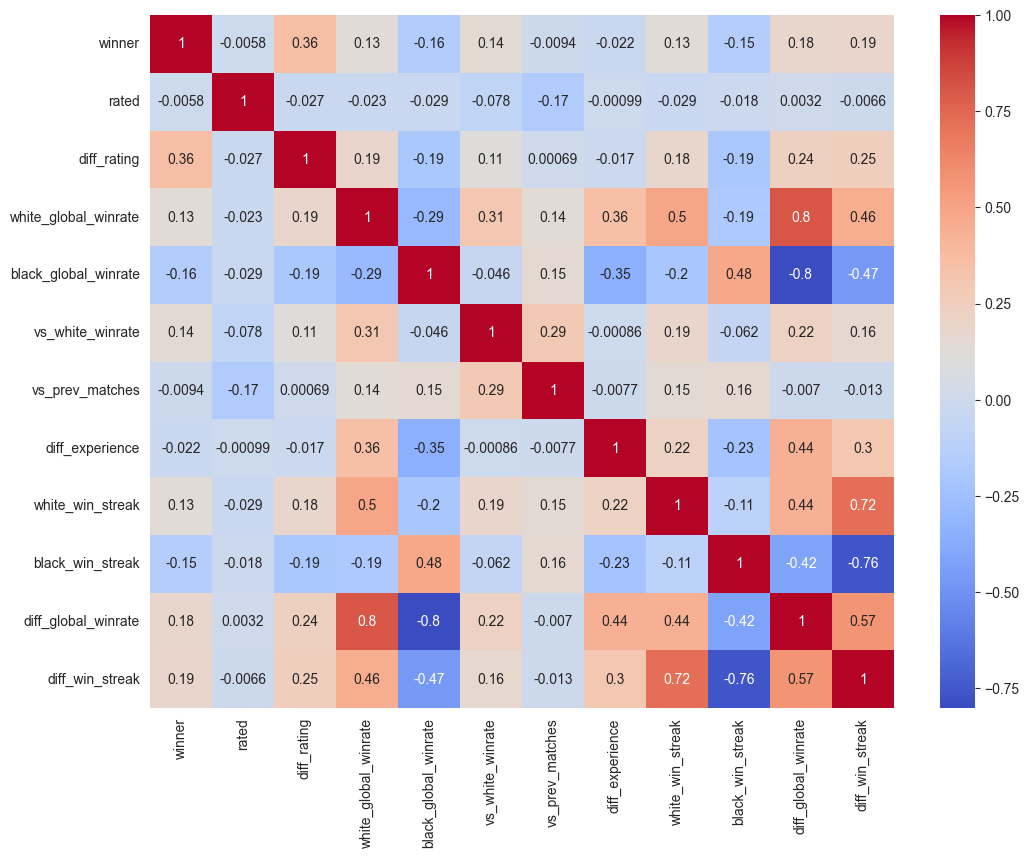

In [32]:
variables_previes = ['winner','rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','diff_experience','white_win_streak','black_win_streak','diff_global_winrate','diff_win_streak']
corr_matrix = df[variables_previes].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

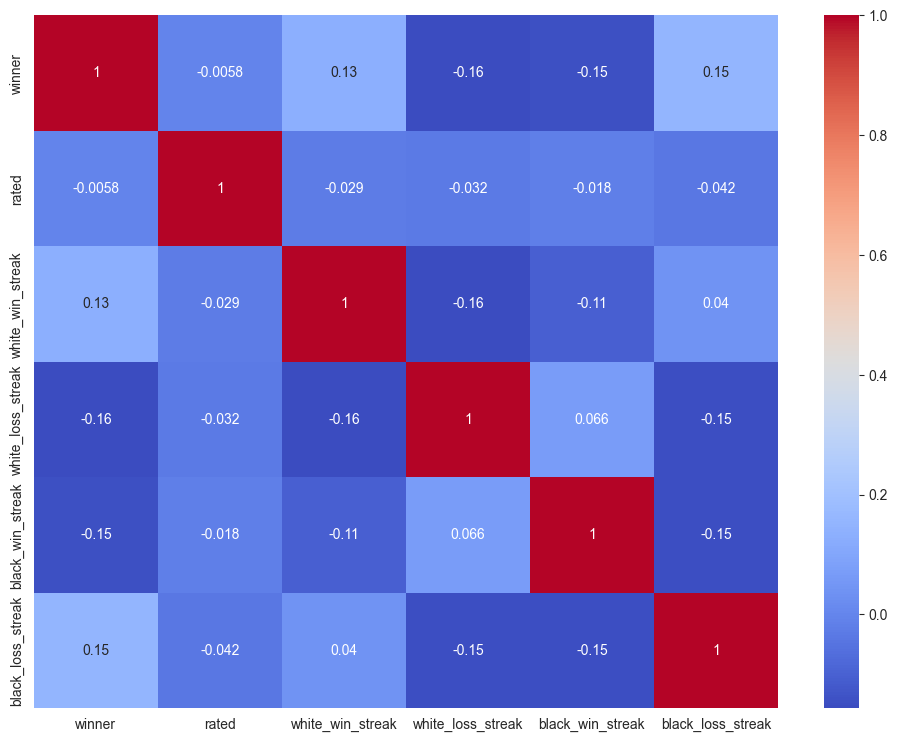

In [33]:
variables_previes = ['winner','rated', 'white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']
corr_matrix = df[variables_previes].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

---

Comencem ara a tractar les variables que es van coneixent a mesura que avança la partida, per veure després l'evolució dels nostres models


Primer canviarem les variables de opening_eco per codificar només el tipus d'apertura:
Códigos ECO (A–E)
* A – Aperturas Flancas y poco comunes
* B – Aperturas Semiabiertas
* C – Aperturas abiertas
* D – Aperturas cerradas y semi-cerradas
* E – Aperturas de peón de dama con defensa india

EXPLICAR MEJOR DESPUÉS

In [34]:
# Crear nueva columna con la primera letra del ECO
df["opening_group"] = df["opening_eco"].astype(str).str[0]
df["opening_group"].value_counts()

opening_group
C    7268
B    4895
A    3656
D    2527
E     474
Name: count, dtype: int64

In [35]:
# les codifiquem per tenir 5 columnes amb True i False
df = pd.get_dummies(df, columns=["opening_group"], drop_first=False)

In [36]:
df.tail()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,white_loss_streak,black_win_streak,black_loss_streak,diff_global_winrate,diff_win_streak,opening_group_A,opening_group_B,opening_group_C,opening_group_D,opening_group_E
13682,qCmTWffu,True,2017-09-04 01:27:41.297,1.504489e+12,55,mate,1,10+0,networkchess2,1940,...,0,0,0,0.666667,2,False,False,False,True,False
16582,5JxE5a6e,True,2017-09-04 01:28:53.111,1.504489e+12,61,mate,1,10+0,elijahreese,1871,...,0,0,0,0.571429,1,True,False,False,False,False
16581,8Xr8Hmp7,True,2017-09-04 01:41:20.676,1.504490e+12,48,resign,0,10+0,elijahreese,1873,...,0,0,0,0.600000,2,False,False,True,False,False
19463,dGvzzC9L,True,2017-09-04 02:30:59.427,1.504493e+12,67,resign,1,10+0,samoo1477,1754,...,0,0,1,0.058140,1,False,False,True,False,False
19462,mLY9CCtH,True,2017-09-04 02:45:43.790,1.504494e+12,65,resign,1,10+0,vertis9016,1822,...,2,2,0,-0.234848,-2,False,False,True,False,False


---

Ara que ja tenim totes les nostres variables explicatives, normalitzem totes les numèriques per tenir-les en el mateix rang.

In [37]:
scaler = StandardScaler()

# Solo normalizamos variables numéricas que nos interesan
num_vars = ['rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','diff_experience','diff_global_winrate','diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']
df[num_vars] = scaler.fit_transform(df[num_vars])

## Metric Selection i Model Base
  * Selecció de la millor mètrica pel problema
  * Visualització de ROC/AUC per model base

In [38]:
def metriques(model,X_test,y_test):
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    
    

def grafiques(model,X_test,y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)


    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 2, figure=fig) 

    # ROC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")

    # Precision-Recall Curve 
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(recall, precision, label=f'AP = {ap:.2f}',color='purple', lw=2)
    ax2.set_ylim(-0.05,1.05)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")

    # Confusion Matrix 
    ax3 = fig.add_subplot(gs[1, :])  
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax3, colorbar=False)
    plt.grid(False)
    ax3.set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()
        

Fem un primer model amb les dades que sabem prèviament al començament de la partida

Logistic Regression
              precision    recall  f1-score   support

           0       0.63      0.58      0.60      1742
           1       0.66      0.70      0.68      2022

    accuracy                           0.65      3764
   macro avg       0.64      0.64      0.64      3764
weighted avg       0.65      0.65      0.65      3764

Accuracy: 0.6466524973432518
F1-score: 0.6815134099616859


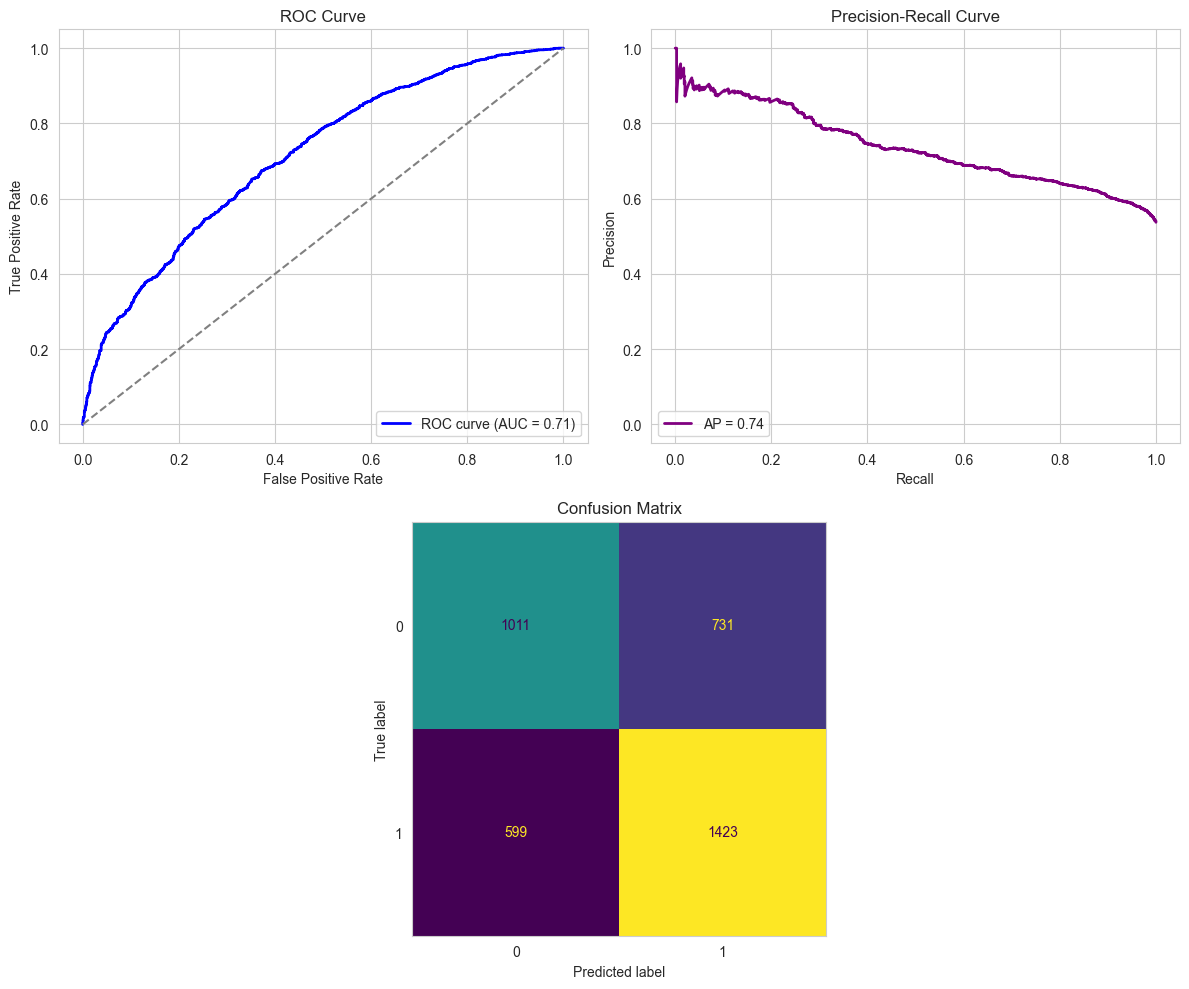

In [39]:
#Model sense les noves variables
explanatory_variables = ['rated', 'white_rating', 'black_rating']
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

print("Logistic Regression")
metriques(log_model,X_test,y_test)
grafiques(log_model,X_test,y_test)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1742
           1       0.67      0.69      0.68      2022

    accuracy                           0.65      3764
   macro avg       0.65      0.65      0.65      3764
weighted avg       0.65      0.65      0.65      3764

Accuracy: 0.6511689691817216
F1-score: 0.6785801713586291


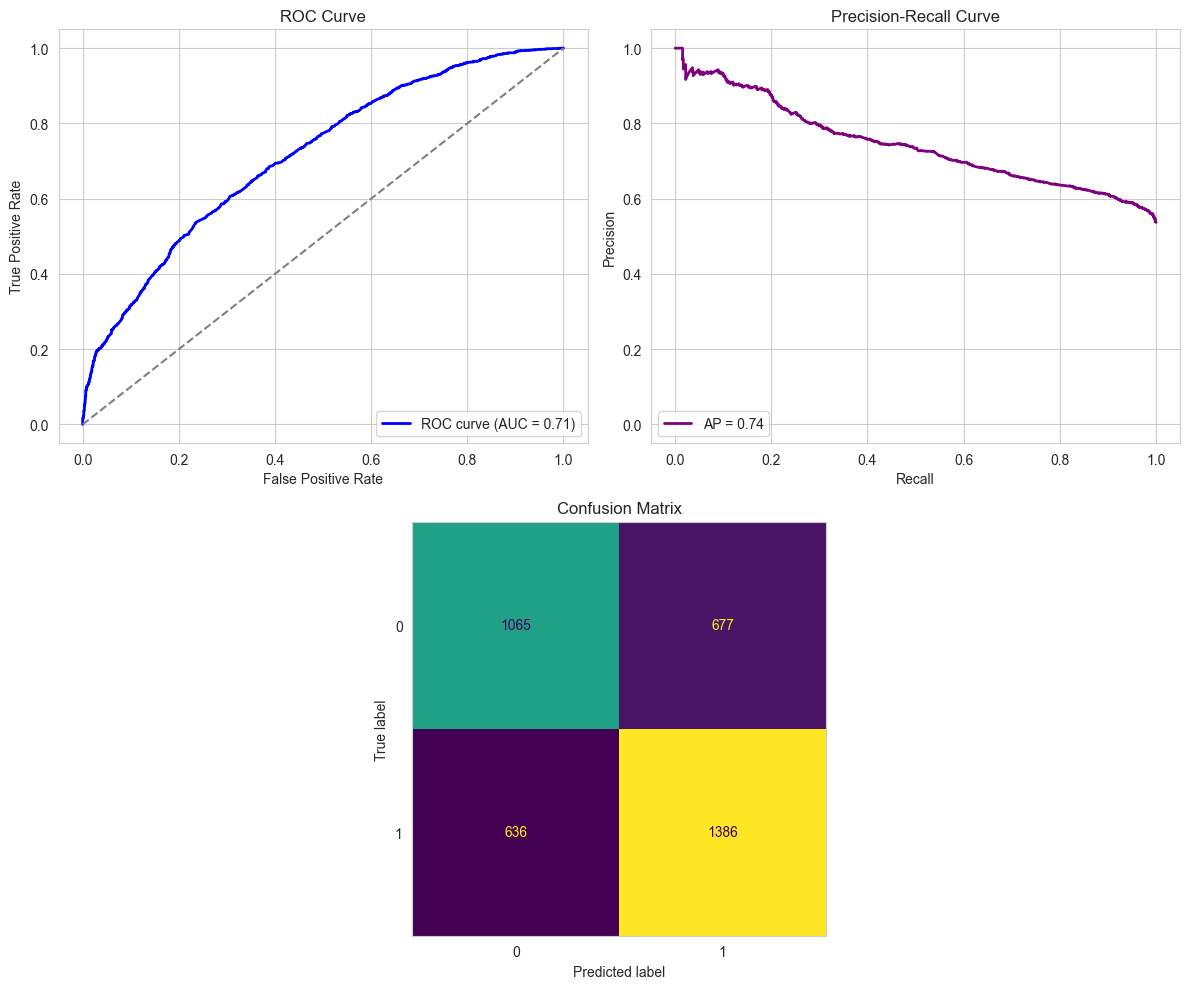

In [40]:
# previ també
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1742
           1       0.68      0.69      0.68      2022

    accuracy                           0.65      3764
   macro avg       0.65      0.65      0.65      3764
weighted avg       0.65      0.65      0.65      3764

Accuracy: 0.6548884165781084
F1-score: 0.681383370125092


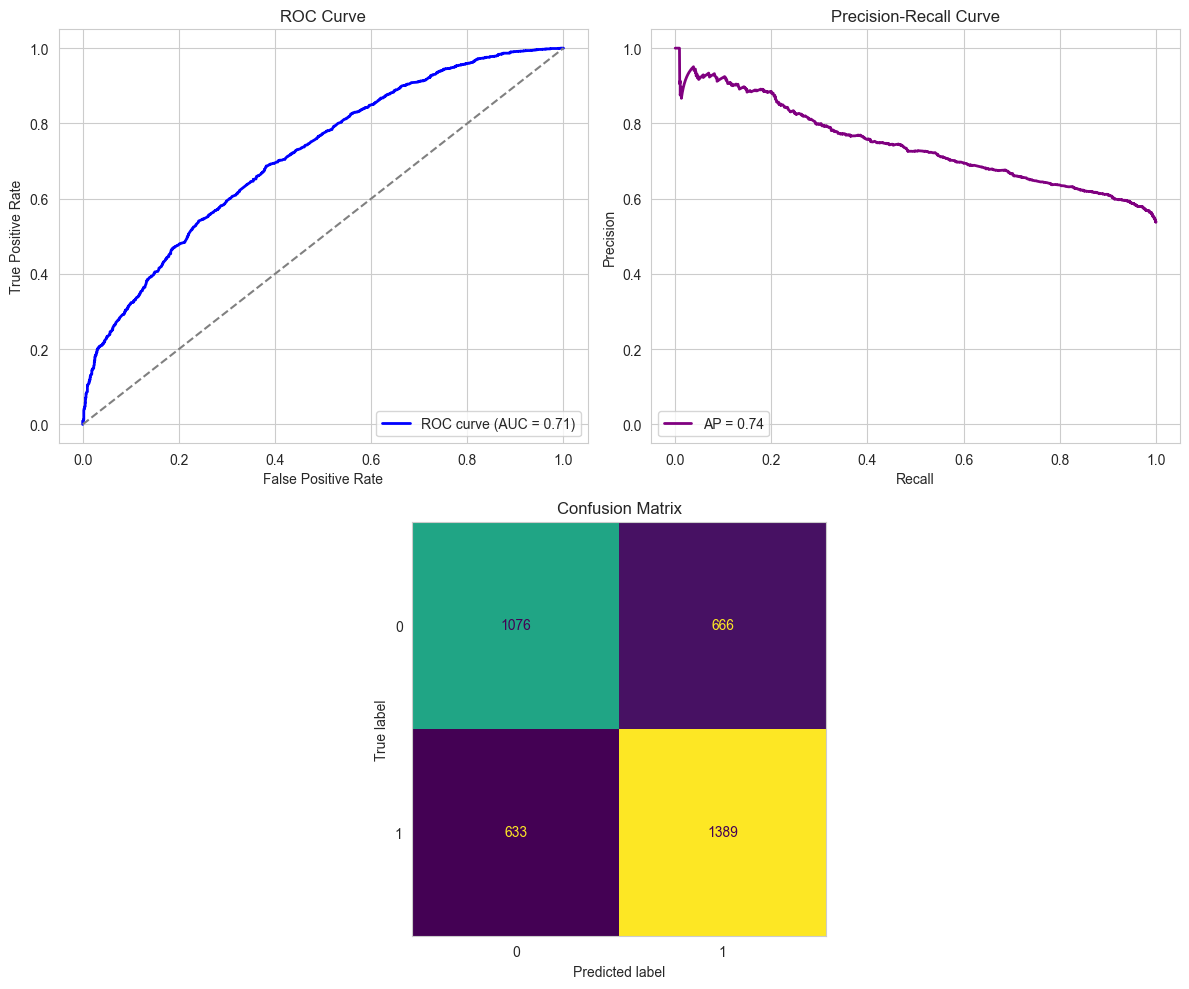

In [41]:
# Volem fer ara dos models de gradient boosting: un només amb la variable "diff_rating" i l'altre amb
# les variables "white_rating" i "black_rating", per veure si hi ha diferència o no

explanatory_variables = ['white_rating', 'black_rating']
target_variable = "winner"
X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)


Gradient Boosting
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      1742
           1       0.66      0.71      0.68      2022

    accuracy                           0.65      3764
   macro avg       0.64      0.64      0.64      3764
weighted avg       0.64      0.65      0.64      3764

Accuracy: 0.6453241232731137
F1-score: 0.6832740213523132


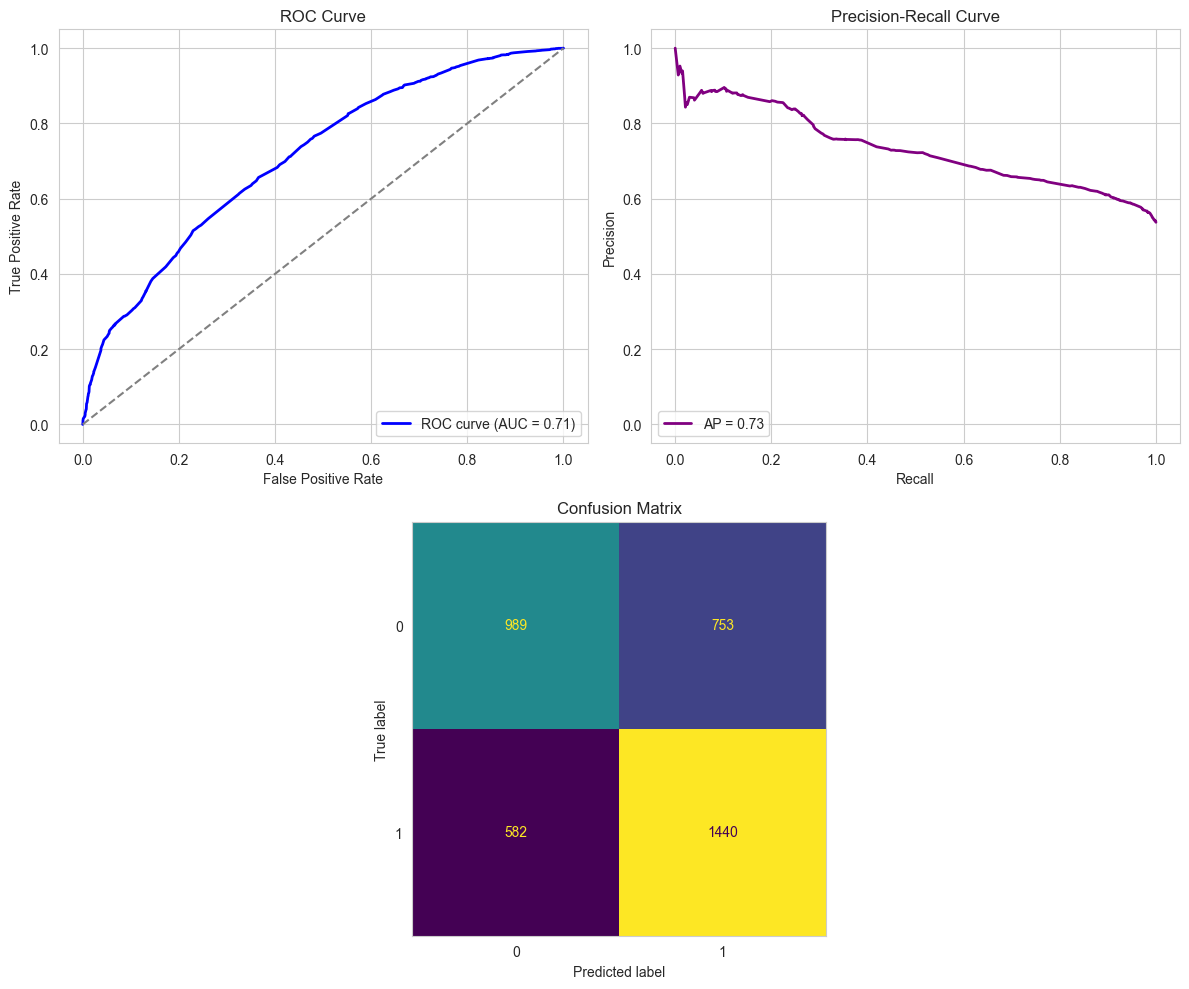

In [42]:
explanatory_variables = ['diff_rating']
target_variable = "winner"
X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)

Afegim les variables creades

Logistic Regression
              precision    recall  f1-score   support

           0       0.63      0.58      0.60      1742
           1       0.66      0.70      0.68      2022

    accuracy                           0.65      3764
   macro avg       0.64      0.64      0.64      3764
weighted avg       0.64      0.65      0.64      3764

Accuracy: 0.645855472901169
F1-score: 0.6808714388316974


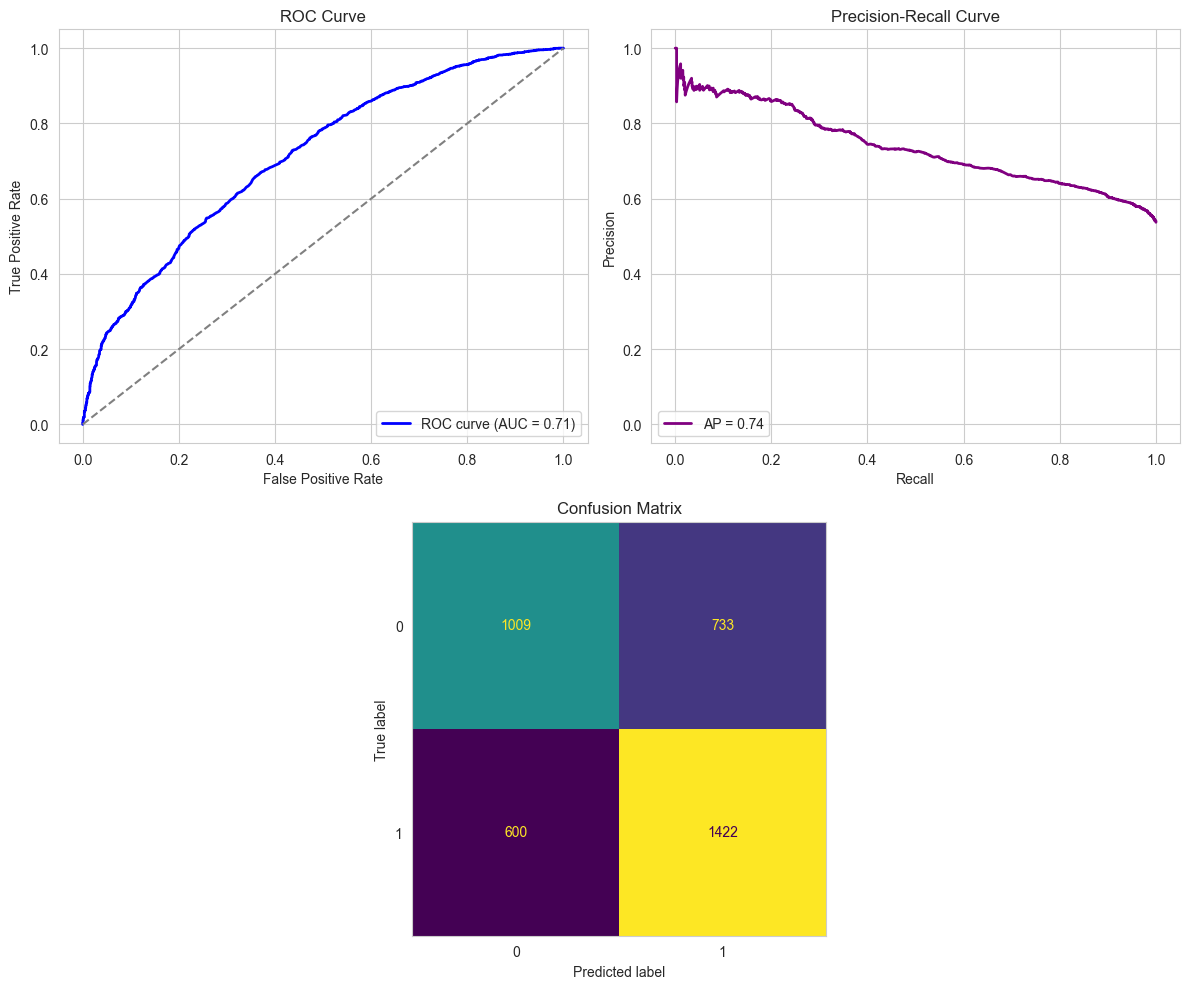

In [43]:
#Model amb només la diff_rating
explanatory_variables = ['rated', 'diff_rating']
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

print("Logistic Regression")
metriques(log_model,X_test,y_test)
grafiques(log_model,X_test,y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1742
           1       0.68      0.69      0.68      2022

    accuracy                           0.66      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.66      0.66      0.66      3764

Accuracy: 0.6583421891604676
F1-score: 0.6834071885770556


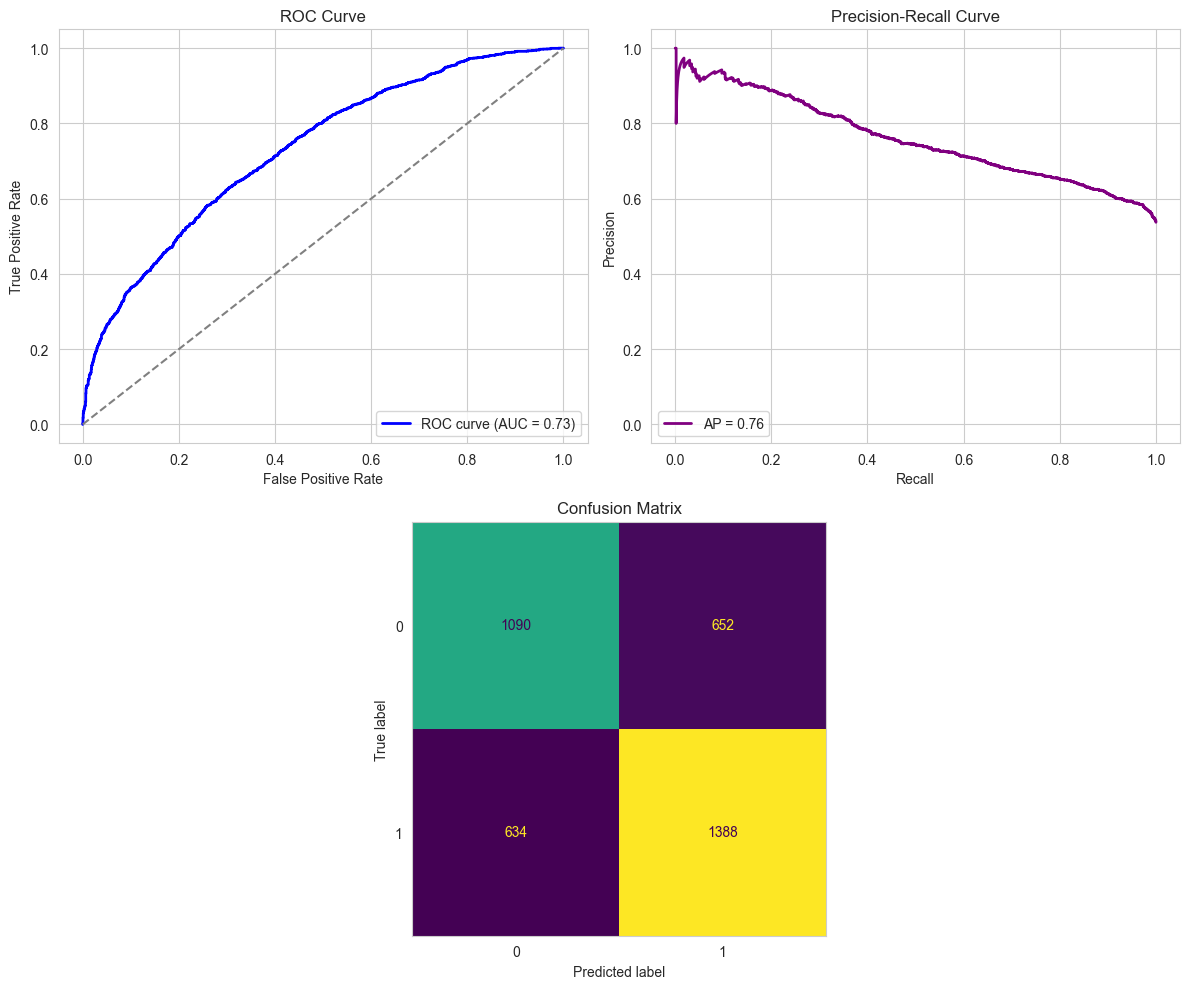

In [44]:
explanatory_variables = ['rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','diff_experience','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

log_model = LogisticRegression(max_iter=4000)
log_model.fit(X_train, y_train)

print("Logistic Regression")
metriques(log_model,X_test,y_test)
grafiques(log_model,X_test,y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1742
           1       0.68      0.68      0.68      2022

    accuracy                           0.66      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.66      0.66      0.66      3764

Accuracy: 0.6578108395324124
F1-score: 0.6803970223325062


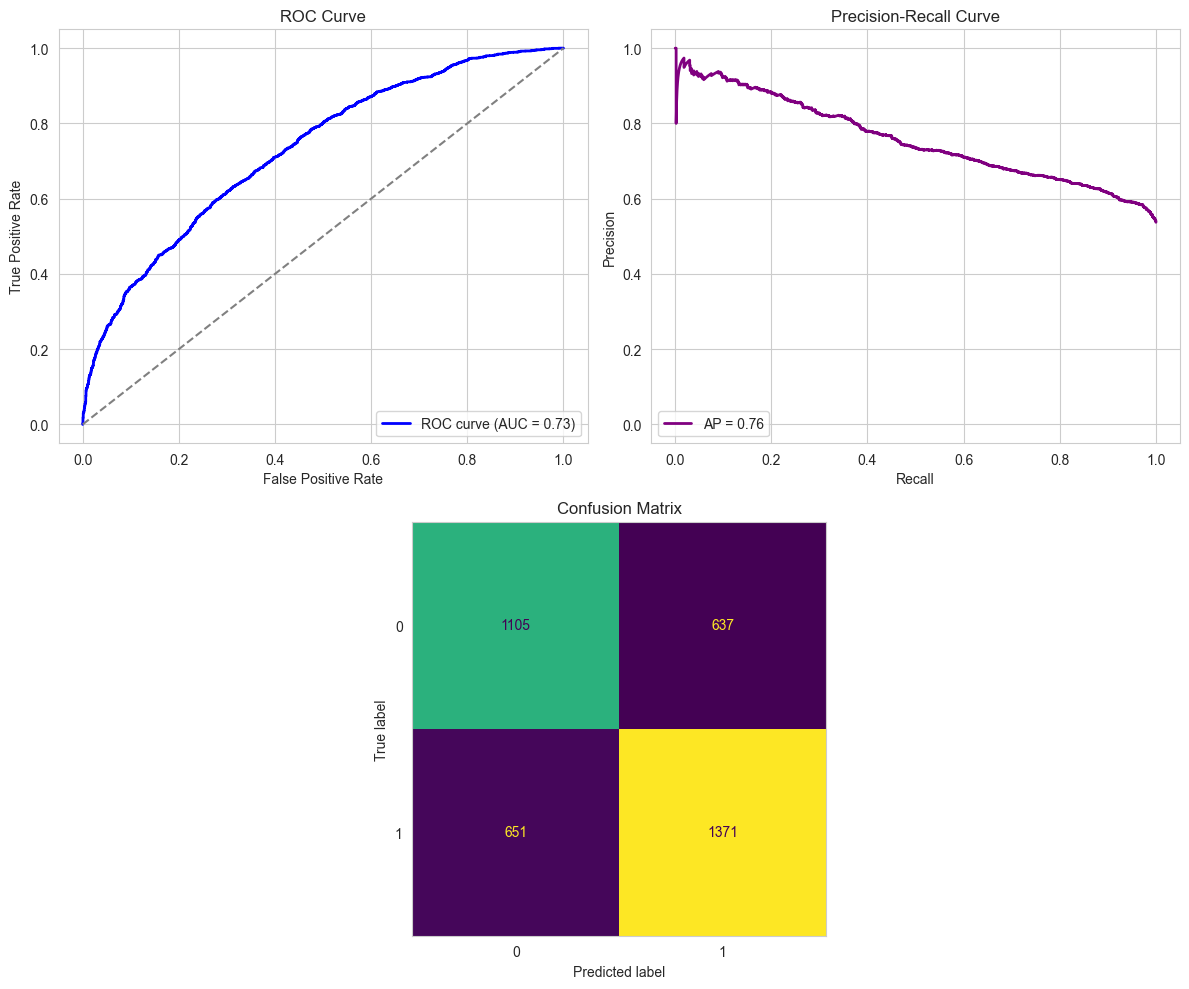

In [45]:
#Cambiem ara les variables de "white_global_wirate" i "black_global_winrate" per "diff_global_winrate"
# i les variables "white_win_streak" i "black_win_streak" per "diff_win_streak", per veure si hi ha alguna 
# diferència.

explanatory_variables = ['rated', 'diff_rating', "diff_global_winrate",'vs_white_winrate', 'vs_prev_matches','diff_experience', 'white_loss_streak','black_loss_streak', "diff_win_streak"]
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

log_model = LogisticRegression(max_iter=4000)
log_model.fit(X_train, y_train)

print("Logistic Regression")
metriques(log_model,X_test,y_test)
grafiques(log_model,X_test,y_test)

In [46]:
"""svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

print("SVM:")
metriques(svm_model,X_test,y_test)
grafiques(svm_model,X_test,y_test)"""

'svm_model = SVC(probability=True)\nsvm_model.fit(X_train, y_train)\n\nprint("SVM:")\nmetriques(svm_model,X_test,y_test)\ngrafiques(svm_model,X_test,y_test)'

Gradient Boosting
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1742
           1       0.69      0.71      0.70      2022

    accuracy                           0.67      3764
   macro avg       0.67      0.67      0.67      3764
weighted avg       0.67      0.67      0.67      3764

Accuracy: 0.6702975557917109
F1-score: 0.6970954356846473


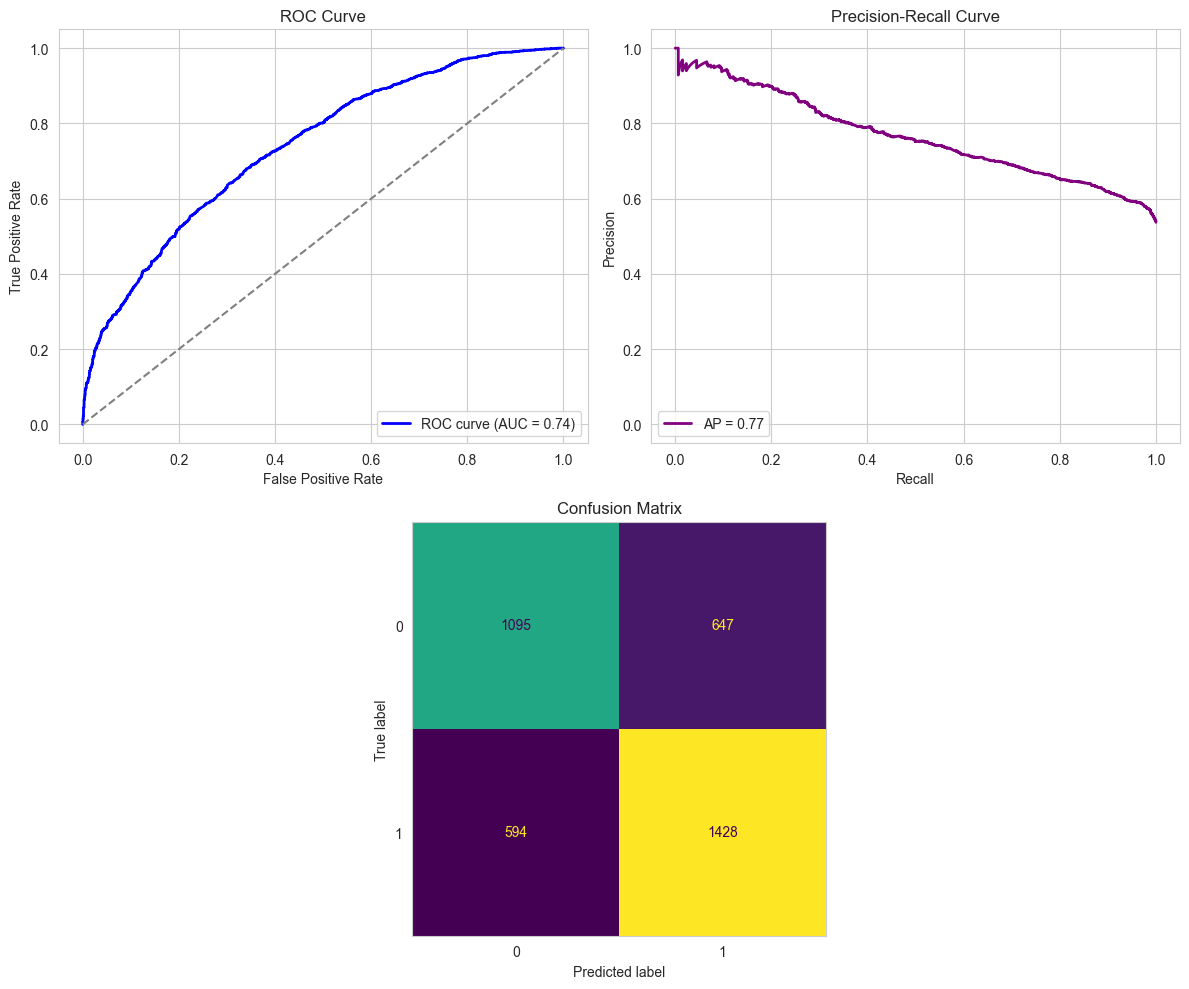

In [47]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)

x Gradient Boost
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1742
           1       0.69      0.69      0.69      2022

    accuracy                           0.66      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.66      0.66      0.66      3764

Accuracy: 0.6641870350690755
F1-score: 0.6891293654697491


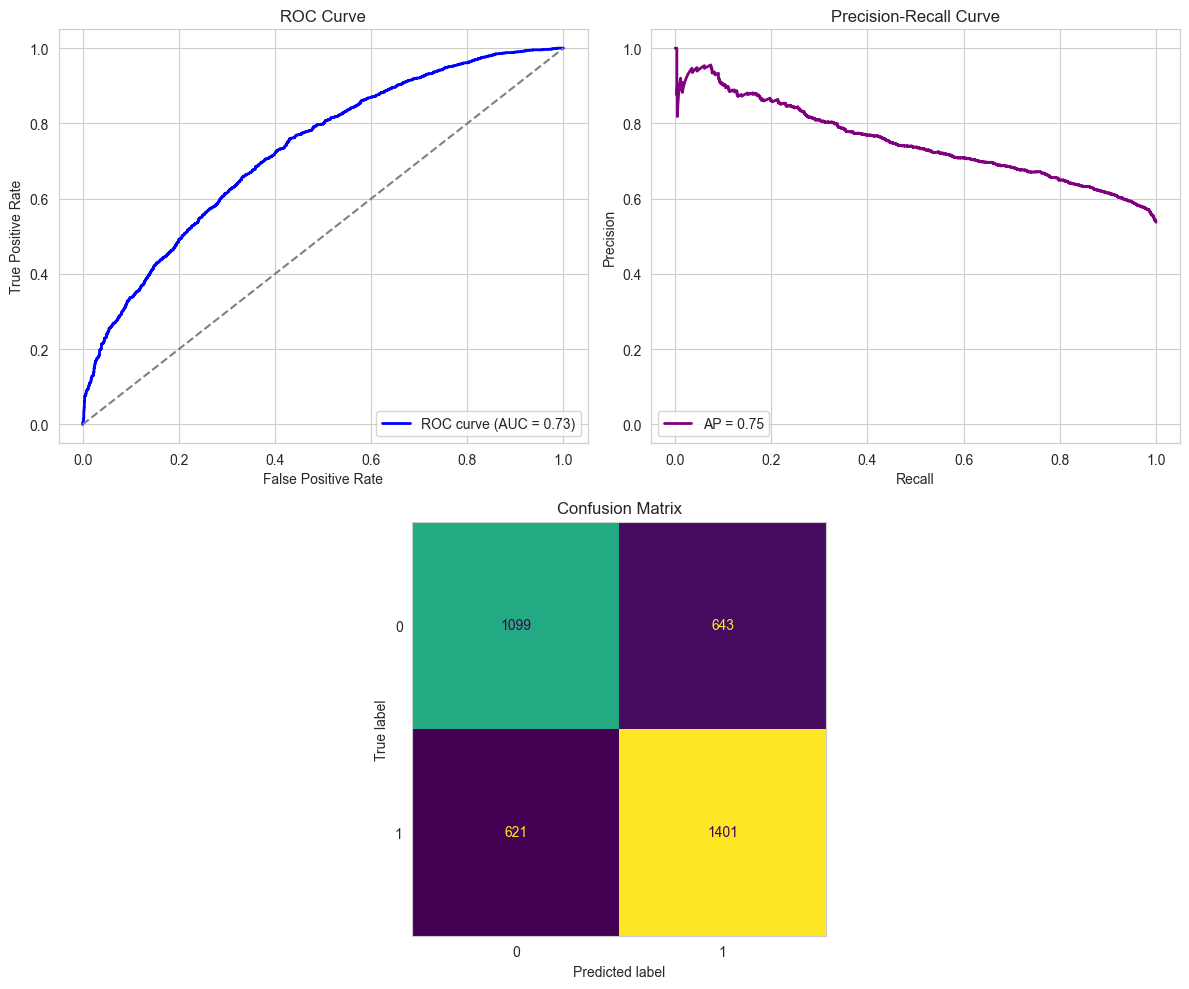

In [48]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

print("x Gradient Boost")
metriques(xgb_model,X_test,y_test)
grafiques(xgb_model,X_test,y_test)

Random Forest
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1742
           1       0.66      0.64      0.65      2022

    accuracy                           0.63      3764
   macro avg       0.63      0.63      0.63      3764
weighted avg       0.63      0.63      0.63      3764

Accuracy: 0.6299149840595112
F1-score: 0.6490299823633157


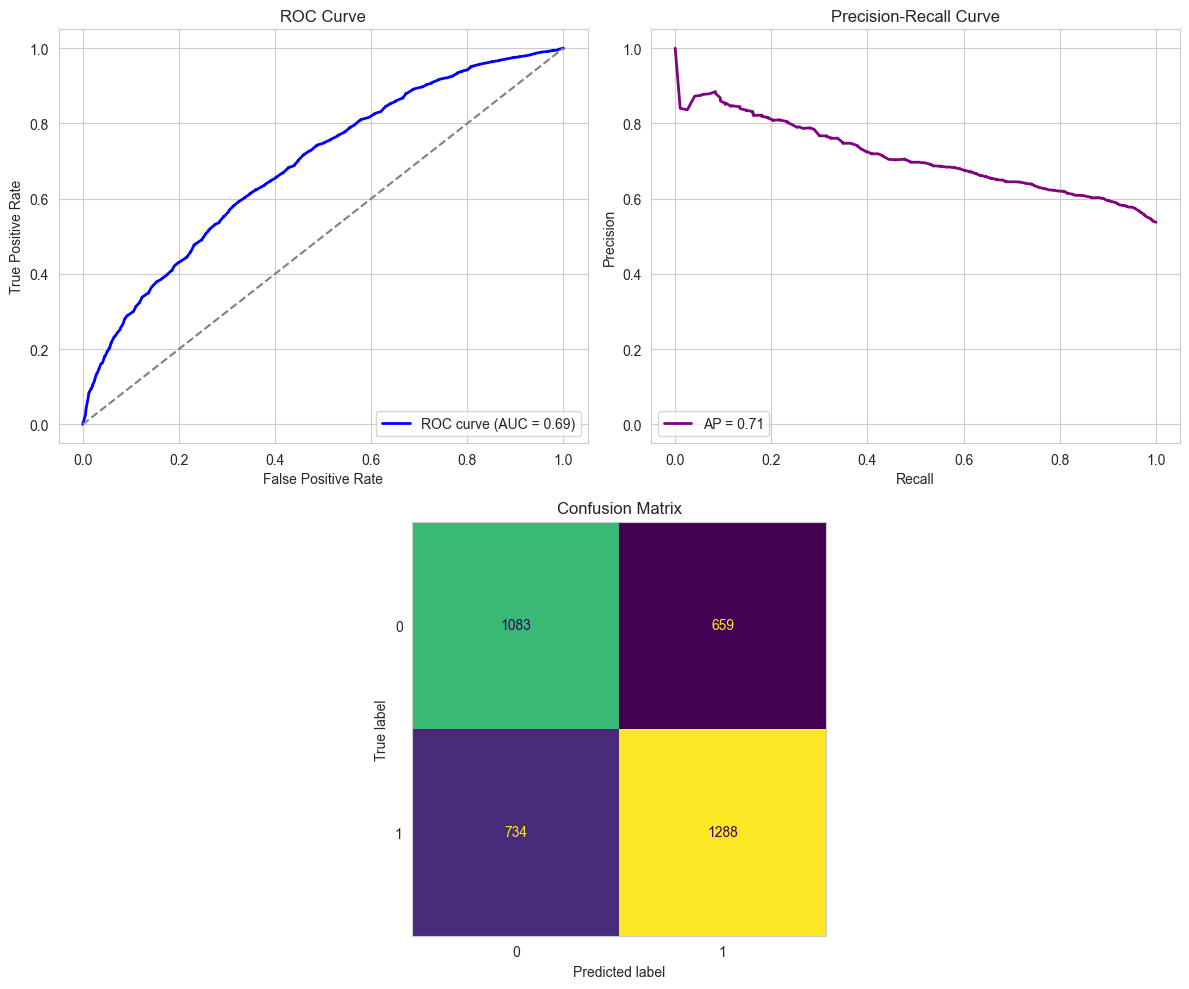

In [49]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

print("Random Forest")
metriques(rf_model,X_test,y_test)
grafiques(rf_model,X_test,y_test)

## Model Selection amb Crossvalidation
  * Selecció del millor model
  * Cerca d'hiperparàmetres

Fem la cerca d'hiperparàmtres pels diferents models. DESCARTAR SVM¿?¿?

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Best CV score: 0.6692353358623515


              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1742
           1       0.68      0.68      0.68      2022

    accuracy                           0.66      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.66      0.66      0.66      3764

Accuracy: 0.6578108395324124
F1-score: 0.6802383316782522


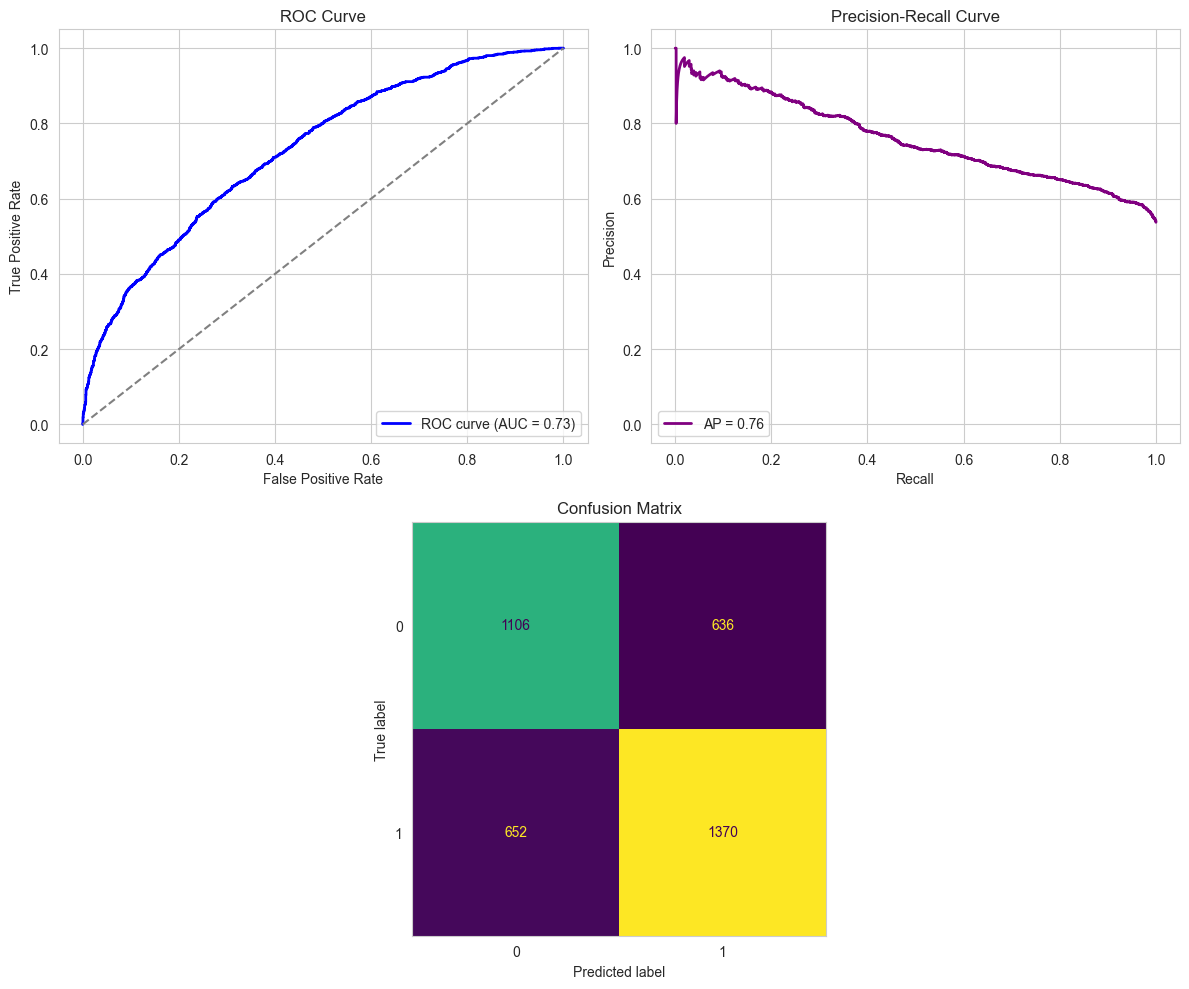

In [50]:
log_reg = LogisticRegression()
param_log = {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l1","l2"], "solver": ["liblinear"]}

grid_log = RandomizedSearchCV(log_reg, param_log, cv=5, scoring="accuracy", verbose=1)
grid_log.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_log.best_params_)
print("Best CV score:", grid_log.best_score_)
print("\n")
metriques(grid_log,X_test,y_test)
grafiques(grid_log,X_test,y_test)

In [51]:
"""gb_model = GradientBoostingClassifier(random_state=42)
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5, 10]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    #n_iter=50,          # número de combinaciones aleatorias a probar
    scoring="accuracy", 
    cv=5,
    n_jobs=-1,
    verbose=2,
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:")
print(random_search.best_params_)

# Evaluar mejor modelo
best_gb = random_search.best_estimator_
print("\nGradient Boosting (RandomizedSearchCV)")
metriques(best_gb, X_test, y_test)
grafiques(best_gb, X_test, y_test)"""

'gb_model = GradientBoostingClassifier(random_state=42)\nparam_dist = {\n    "n_estimators": [100, 200, 300],\n    "learning_rate": [0.01, 0.05, 0.1],\n    "max_depth": [2, 3, 4],\n    "subsample": [0.8, 1.0],\n    "min_samples_split": [2, 5, 10]\n}\n\n# RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    estimator=gb_model,\n    param_distributions=param_dist,\n    #n_iter=50,          # número de combinaciones aleatorias a probar\n    scoring="accuracy", \n    cv=5,\n    n_jobs=-1,\n    verbose=2,\n)\n\nrandom_search.fit(X_train, y_train)\n\n# Mejores hiperparámetros\nprint("Mejores hiperparámetros:")\nprint(random_search.best_params_)\n\n# Evaluar mejor modelo\nbest_gb = random_search.best_estimator_\nprint("\nGradient Boosting (RandomizedSearchCV)")\nmetriques(best_gb, X_test, y_test)\ngrafiques(best_gb, X_test, y_test)'

In [52]:
"""rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    #n_iter=50,           # número de combinaciones aleatorias a probar
    scoring="accuracy", 
    cv=5,
    n_jobs=-1,
    verbose=2,
)

random_search_rf.fit(X_train, y_train)

print("Mejores hiperparámetros Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_

print("\nRandom Forest (RandomizedSearchCV)")
metriques(best_rf, X_test, y_test)
grafiques(best_rf, X_test, y_test)"""

'rf_model = RandomForestClassifier(random_state=42)\n\nparam_dist = {\n    "n_estimators": [100, 200, 300, 400],\n    "max_depth": [None, 5, 10, 20],\n    "min_samples_split": [2, 5, 10],\n    "min_samples_leaf": [1, 2, 4],\n    "max_features": ["auto", "sqrt", "log2"],\n    "bootstrap": [True, False]\n}\n\nrandom_search_rf = RandomizedSearchCV(\n    estimator=rf_model,\n    param_distributions=param_dist,\n    #n_iter=50,           # número de combinaciones aleatorias a probar\n    scoring="accuracy", \n    cv=5,\n    n_jobs=-1,\n    verbose=2,\n)\n\nrandom_search_rf.fit(X_train, y_train)\n\nprint("Mejores hiperparámetros Random Forest:")\nprint(random_search_rf.best_params_)\n\nbest_rf = random_search_rf.best_estimator_\n\nprint("\nRandom Forest (RandomizedSearchCV)")\nmetriques(best_rf, X_test, y_test)\ngrafiques(best_rf, X_test, y_test)'

---

## METEMOS LOS MOVIMIENTOS

Gradient Boosting
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1742
           1       0.69      0.70      0.70      2022

    accuracy                           0.67      3764
   macro avg       0.67      0.67      0.67      3764
weighted avg       0.67      0.67      0.67      3764

Accuracy: 0.6708289054197663
F1-score: 0.6969919295671313


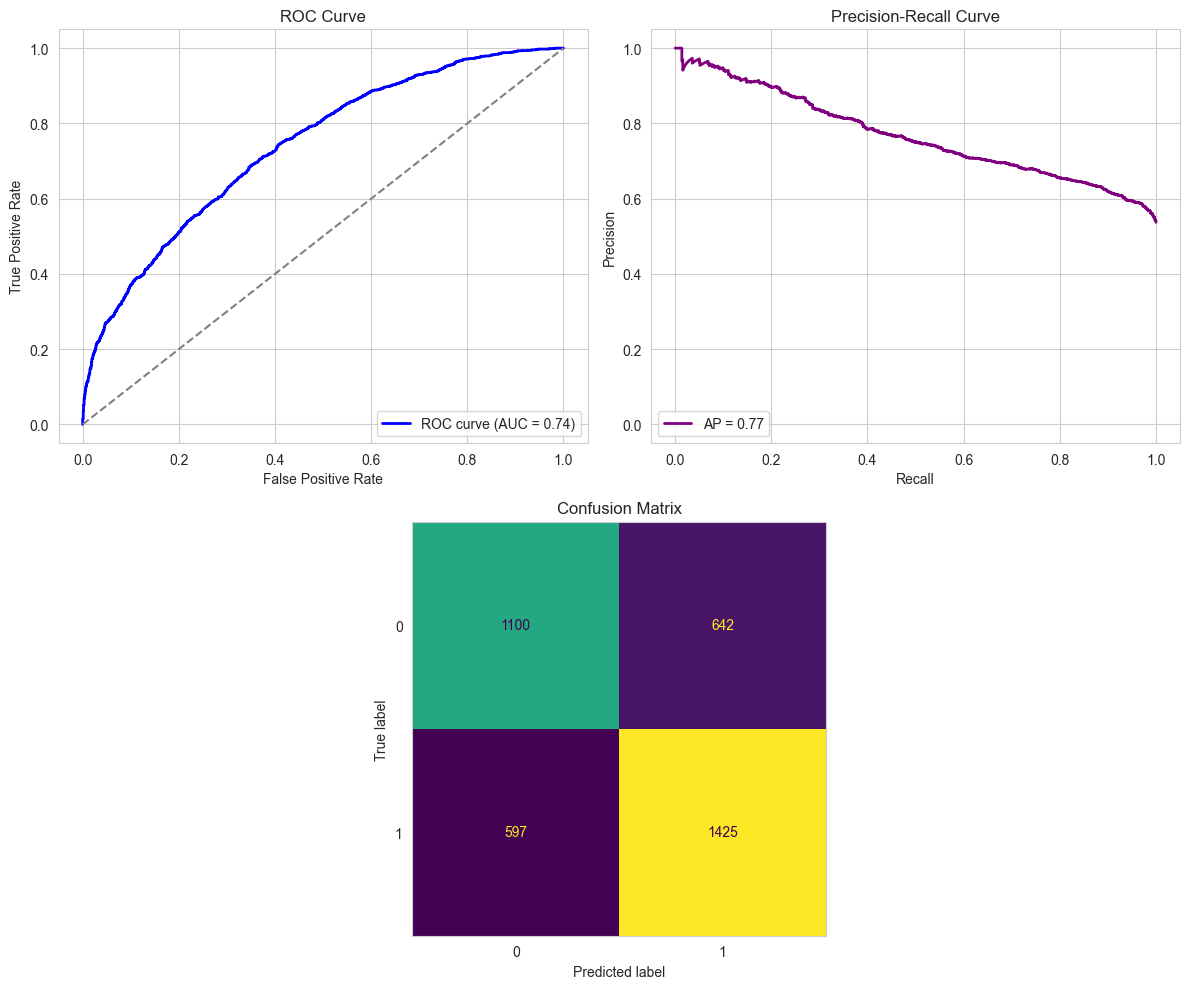

In [53]:
# Primero añado el 

explanatory_variables = ['rated', 'opening_group_A', 'opening_group_B', 'opening_group_C', 'opening_group_D','opening_ply',
                         'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches',
                         'diff_experience','diff_global_winrate',
                         'diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak'] # YA LAS PONDREMOS BIEN, EN PLAN LAS DEFINITIVAS
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)

In [54]:
df['moves'] # Mirem la notació en que tenim els moviments de la partida

10854    e4 e5 Qh5 Nf6 Qxe5+ Be7 b3 d6 Qb5+ c6 Qb4 c5 Q...
10853    e4 g6 d4 Bg7 Nf3 b6 Nc3 Bb7 Bc4 e6 Bg5 Ne7 O-O...
10852    e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5 Bb3 Bc5 Nxe5 Nxe5 ...
10851    e4 e5 Nf3 f6 Bc4 Bc5 d4 d5 Bb5+ c6 Ba4 Bb4+ Nb...
10850    e4 Nf6 Nc3 Nc6 Bc4 d6 d3 g6 h3 b6 Nf3 Ne5 Nxe5...
                               ...                        
13682    d4 c6 Nf3 d5 c4 Nf6 Bg5 e6 e3 Be7 Nc3 O-O Bd3 ...
16582    e4 d6 d4 g6 c4 Bg7 Nc3 Nd7 Nf3 b6 Bf4 Bb7 Bd3 ...
16581    e4 e5 Nf3 f5 d3 Nf6 exf5 Nc6 Bg5 d5 Nc3 Be7 Be...
19463    e4 e6 d4 d5 Nd2 Ne7 c3 dxe4 Nxe4 Nf5 Nf3 Bd6 B...
19462    d4 e6 e4 d5 e5 c5 c3 Qb6 Nf3 Nc6 Bd3 cxd4 cxd4...
Name: moves, Length: 18820, dtype: object

DEFINO FUNCIONES PARA HACER FEATURE ENGINEERING CON LOS MOVIMIENTOS

In [55]:
import chess

# Funcion que me devuelve el estado del tablero a partir de los movimientos
def board_after_n_moves(moves_str, n_moves=None):
    board = chess.Board()
    moves = moves_str.split()
    
    if n_moves is not None:
        moves = moves[:n_moves]

    for mv in moves:
        try:
            board.push_san(mv)  # SAN = notación estándar que tú tienes
        except:
            break  # por si algún movimiento está mal anotado

    return board


piece_values = {
    chess.PAWN:   1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK:   5,
    chess.QUEEN:  9,
    chess.KING:   0
}

# Funcion que me devuelve las nuevas variables creadas. (nº de piezas, valor de las piezas)
def material_features(board):
    white_total = 0
    black_total = 0
    white_count = 0
    black_count = 0
    
    for piece in board.piece_map().values():
        value = piece_values[piece.piece_type]
        
        if piece.color == chess.WHITE:
            white_total += value
            white_count += 1
        else:
            black_total += value
            black_count += 1
    
    return {
        "white_piece_count": white_count,
        "black_piece_count": black_count,
        "white_material_value": white_total,
        "black_material_value": black_total,
        "material_balance": white_total - black_total
    }

CENTER_SQUARES = [
    chess.D4, chess.E4, chess.D5, chess.E5
]

# Funcion que devuelve los valores para evaluar el control del centro del tablero
def center_control(board):    
    white = 0
    black = 0
    
    for sq in CENTER_SQUARES: 
        attackers_white = board.attackers(chess.WHITE, sq) # Devuelve los atacantes de una casilla específica por color
        attackers_black = board.attackers(chess.BLACK, sq)
        
        if attackers_white:
            white += 1
        if attackers_black:
            black += 1
            
    return {
        "white_center_control": white,
        "black_center_control": black
    }


In [56]:
def extract_features_from_moves(moves_str, n_moves=None):
    board = board_after_n_moves(moves_str, n_moves)
    
    feats = {}
    feats.update(material_features(board))
    feats.update(center_control(board))
    
    return feats

In [57]:
# pruebo las funciones
moves = "e4 e5 Qh5 Nf6 Qxe5+ Be7"

features = extract_features_from_moves(moves, n_moves=6)
print(features)

{'white_piece_count': 16, 'black_piece_count': 15, 'white_material_value': 39, 'black_material_value': 38, 'material_balance': 1, 'white_center_control': 3, 'black_center_control': 2}


In [58]:
# añado las nuevas features a mi dataset
def add_move_features(df, n_moves=None):
    feature_rows = []

    for moves in df["moves"]:
        feature_rows.append(extract_features_from_moves(moves, n_moves))

    feature_df = pd.DataFrame(feature_rows)
    return pd.concat([df, feature_df], axis=1)

In [59]:
# 1) Contar plies
def count_plies(moves_str):
    if pd.isna(moves_str):
        return 0
    return len(moves_str.split())

N_PLIES = 40

df["num_plies"] = df["moves"].apply(count_plies)

# 2) Filtrar antes de añadir features basadas en N movimientos
df_filtered = df[df["num_plies"] >= N_PLIES].copy()
df_filtered.reset_index(drop=True, inplace=True)

# 3) Añadir features SOLO a estas filas
df_filtered = add_move_features(df_filtered, n_moves=N_PLIES)

df_filtered.isna().sum()[['white_piece_count','black_piece_count','white_material_value','black_material_value']]


white_piece_count       0
black_piece_count       0
white_material_value    0
black_material_value    0
dtype: int64

Gradient Boosting
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1322
           1       0.73      0.74      0.74      1399

    accuracy                           0.73      2721
   macro avg       0.73      0.73      0.73      2721
weighted avg       0.73      0.73      0.73      2721

Accuracy: 0.7295112091142962
F1-score: 0.738450604122246


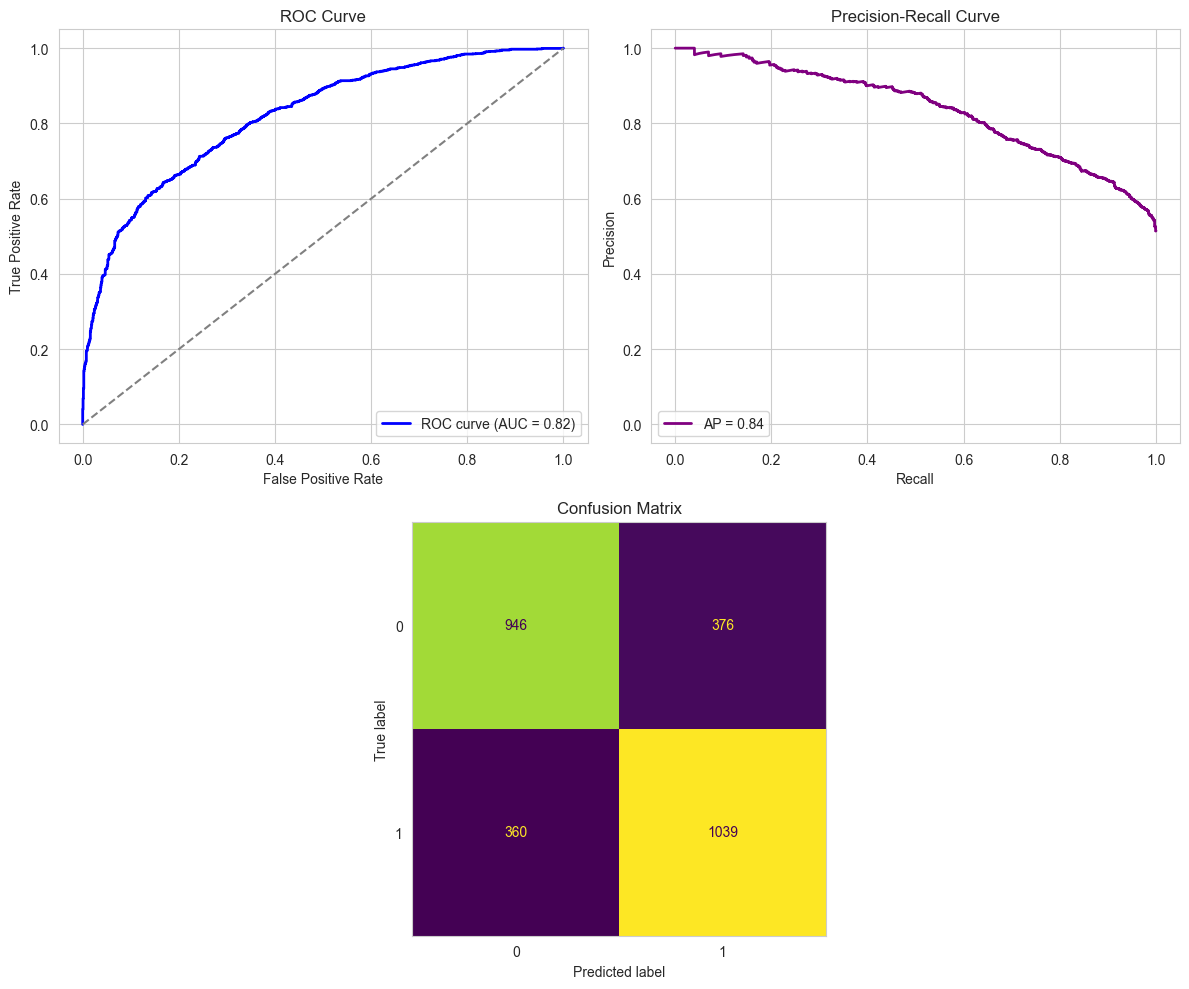

In [60]:
explanatory_variables = [
    'rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate',
    'vs_prev_matches','diff_experience','diff_global_winrate',
    'diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak',
    'white_piece_count','black_piece_count', 'white_material_value', 'black_material_value', 'material_balance',
    'white_center_control', 'black_center_control'
]

X = df_filtered[explanatory_variables]
y = df_filtered["winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5
)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model, X_test, y_test)
grafiques(gb_model, X_test, y_test)

In [61]:
print(df['turns'].median())

55.0



N_PLIES = 4
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1742
           1       0.69      0.70      0.70      2022

    accuracy                           0.67      3764
   macro avg       0.67      0.67      0.67      3764
weighted avg       0.67      0.67      0.67      3764

Accuracy: 0.6721572794899043
F1-score: 0.6969548133595285


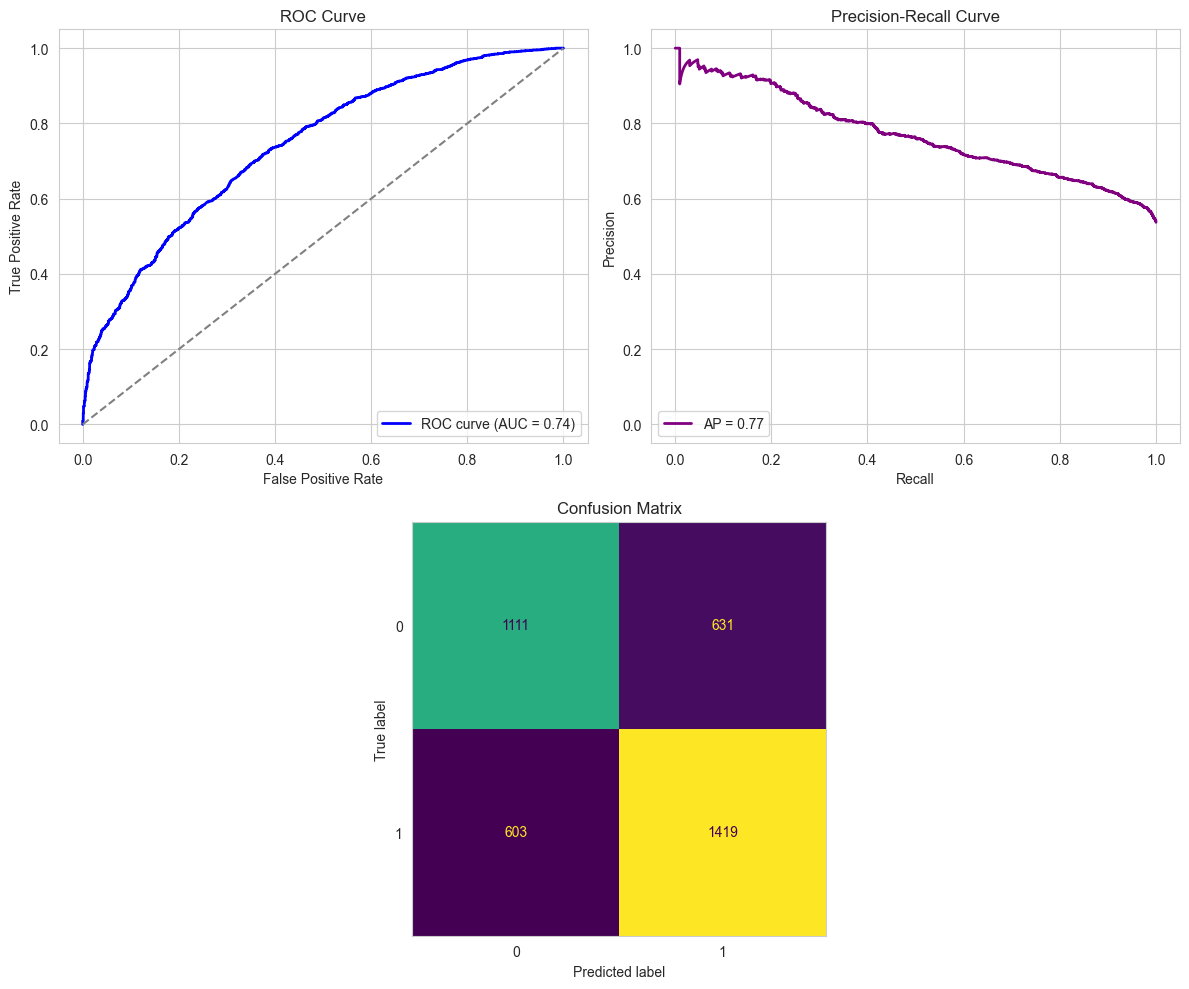


N_PLIES = 8
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      1758
           1       0.69      0.73      0.71      1970

    accuracy                           0.68      3728
   macro avg       0.68      0.68      0.68      3728
weighted avg       0.68      0.68      0.68      3728

Accuracy: 0.683744635193133
F1-score: 0.7092478421701603


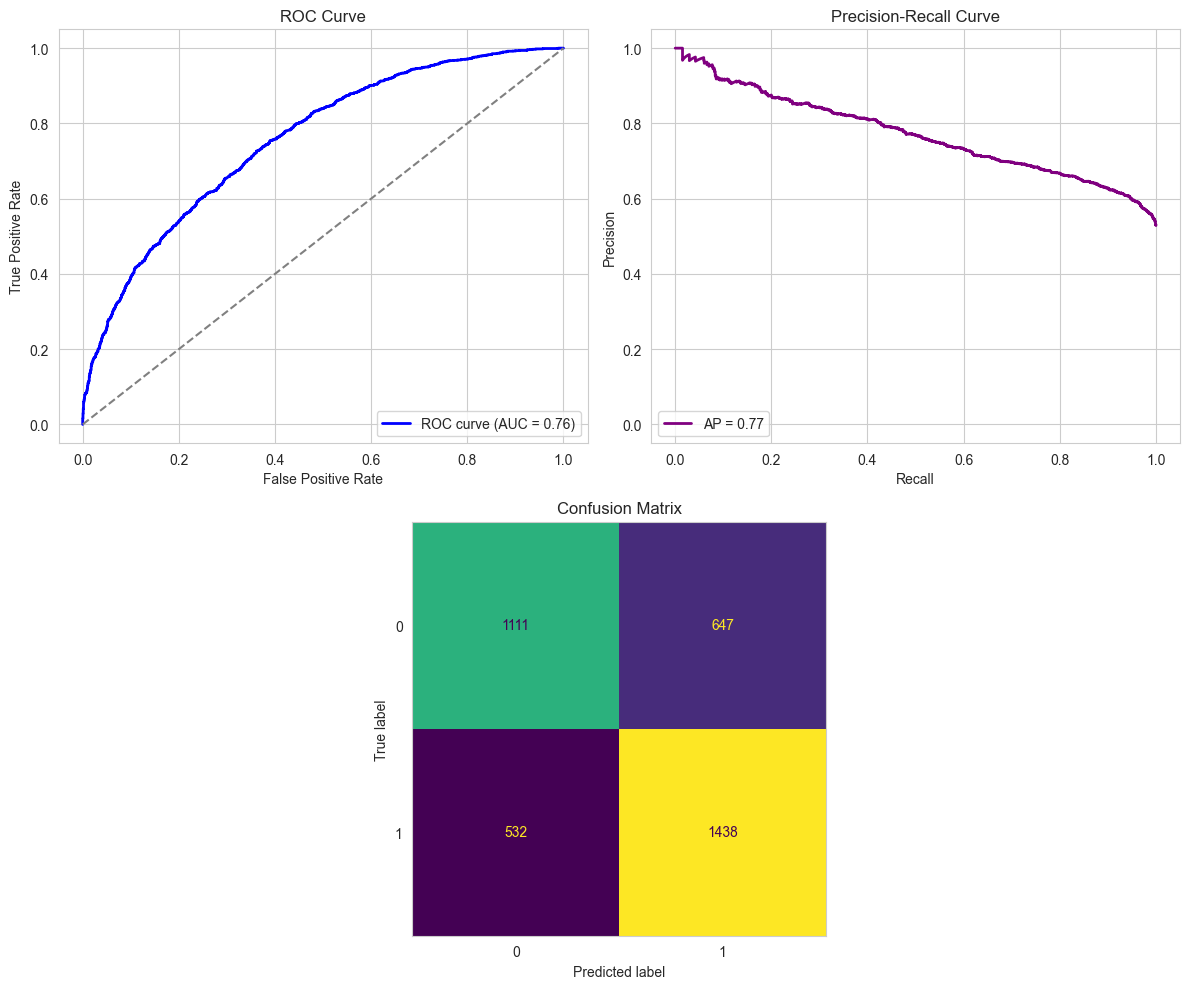


N_PLIES = 16
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1720
           1       0.68      0.71      0.70      1880

    accuracy                           0.68      3600
   macro avg       0.68      0.68      0.68      3600
weighted avg       0.68      0.68      0.68      3600

Accuracy: 0.6786111111111112
F1-score: 0.6983050847457627


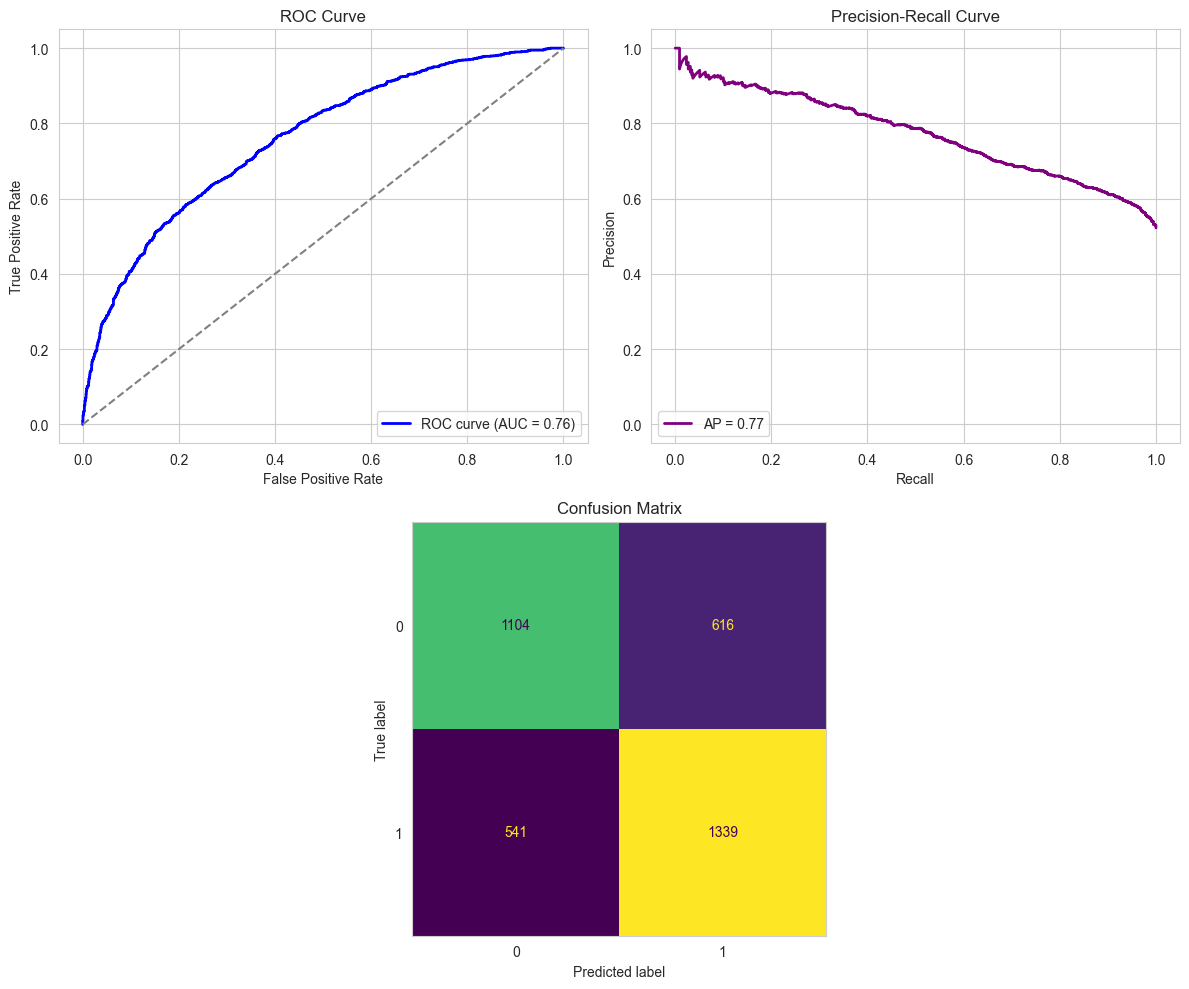


N_PLIES = 20
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1646
           1       0.70      0.70      0.70      1857

    accuracy                           0.68      3503
   macro avg       0.68      0.68      0.68      3503
weighted avg       0.68      0.68      0.68      3503

Accuracy: 0.6802740508135884
F1-score: 0.6989247311827957


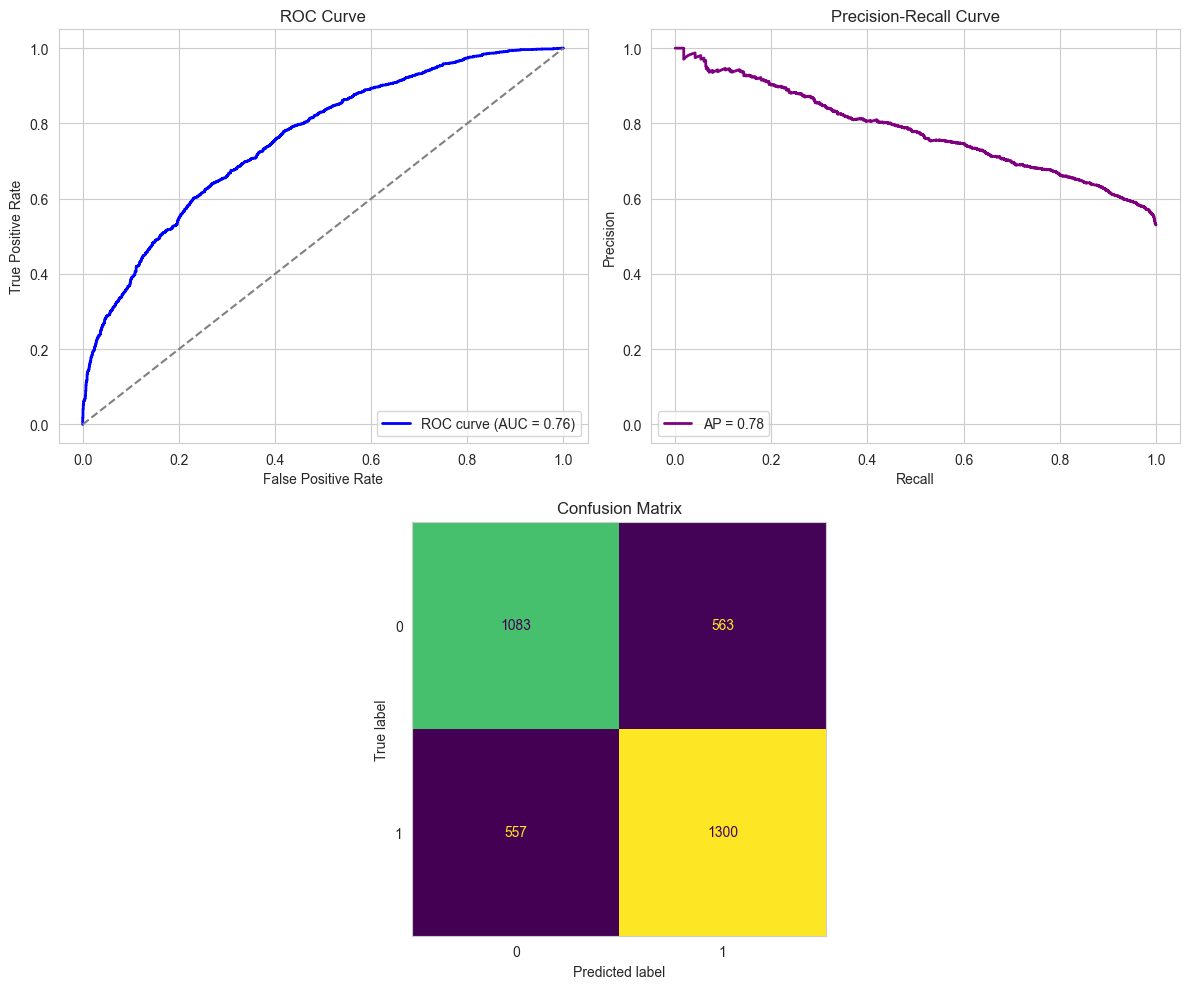


N_PLIES = 30
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1564
           1       0.71      0.70      0.71      1613

    accuracy                           0.71      3177
   macro avg       0.71      0.71      0.71      3177
weighted avg       0.71      0.71      0.71      3177

Accuracy: 0.7053824362606232
F1-score: 0.708411214953271


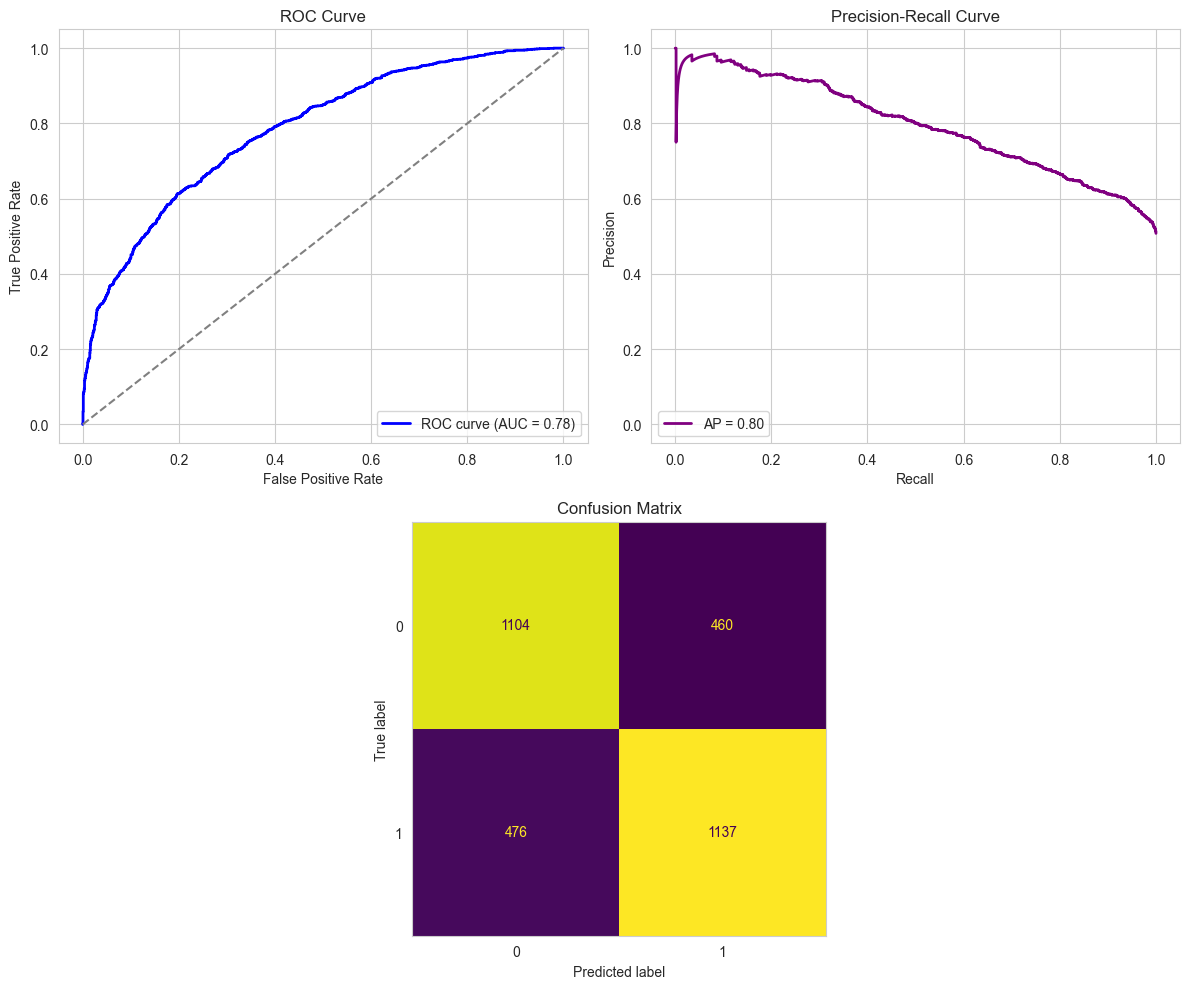


N_PLIES = 40
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1322
           1       0.73      0.74      0.74      1399

    accuracy                           0.73      2721
   macro avg       0.73      0.73      0.73      2721
weighted avg       0.73      0.73      0.73      2721

Accuracy: 0.7295112091142962
F1-score: 0.738450604122246


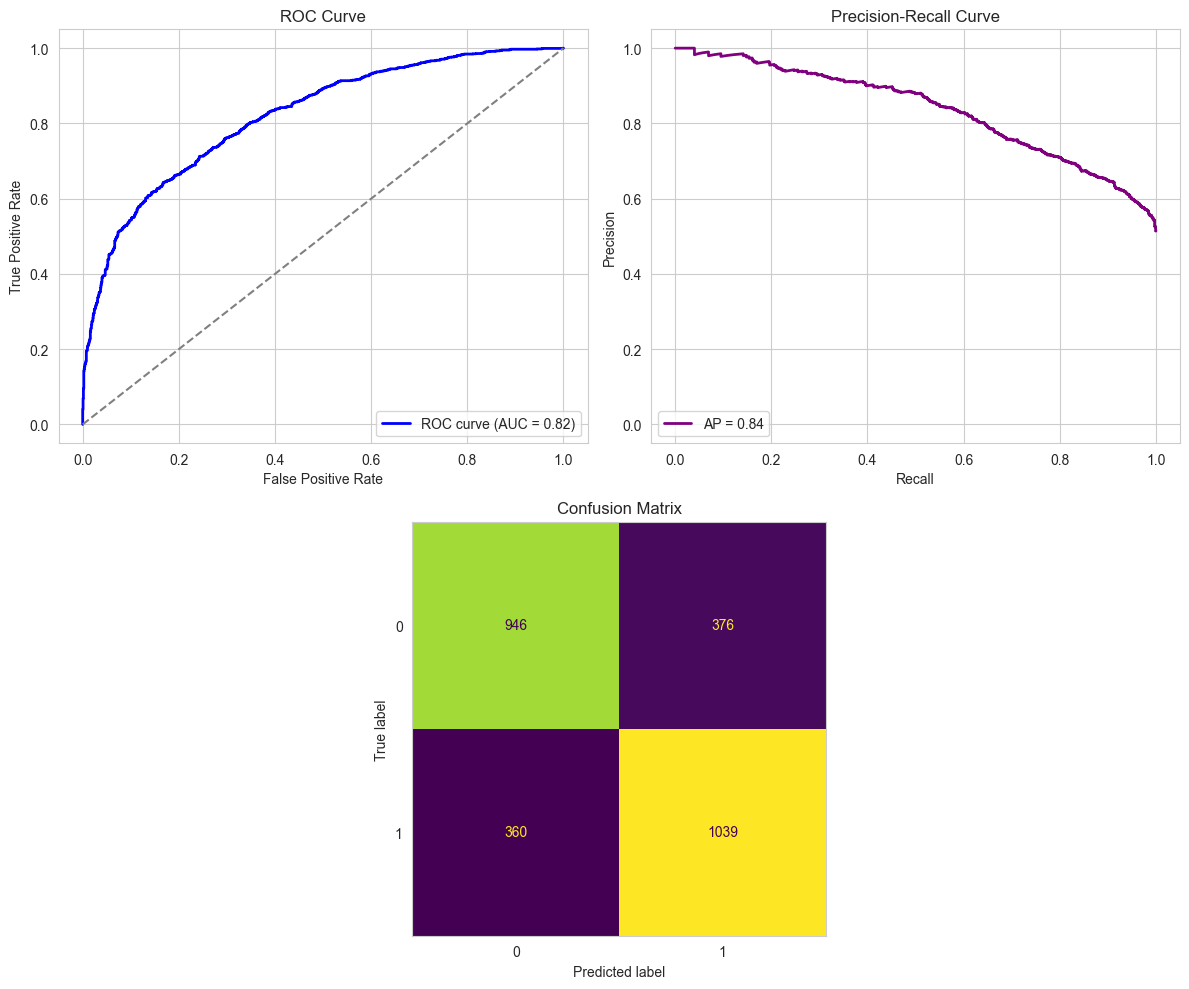


N_PLIES = 60
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       811
           1       0.81      0.77      0.79       836

    accuracy                           0.79      1647
   macro avg       0.79      0.79      0.79      1647
weighted avg       0.79      0.79      0.79      1647

Accuracy: 0.7917425622343656
F1-score: 0.788923076923077


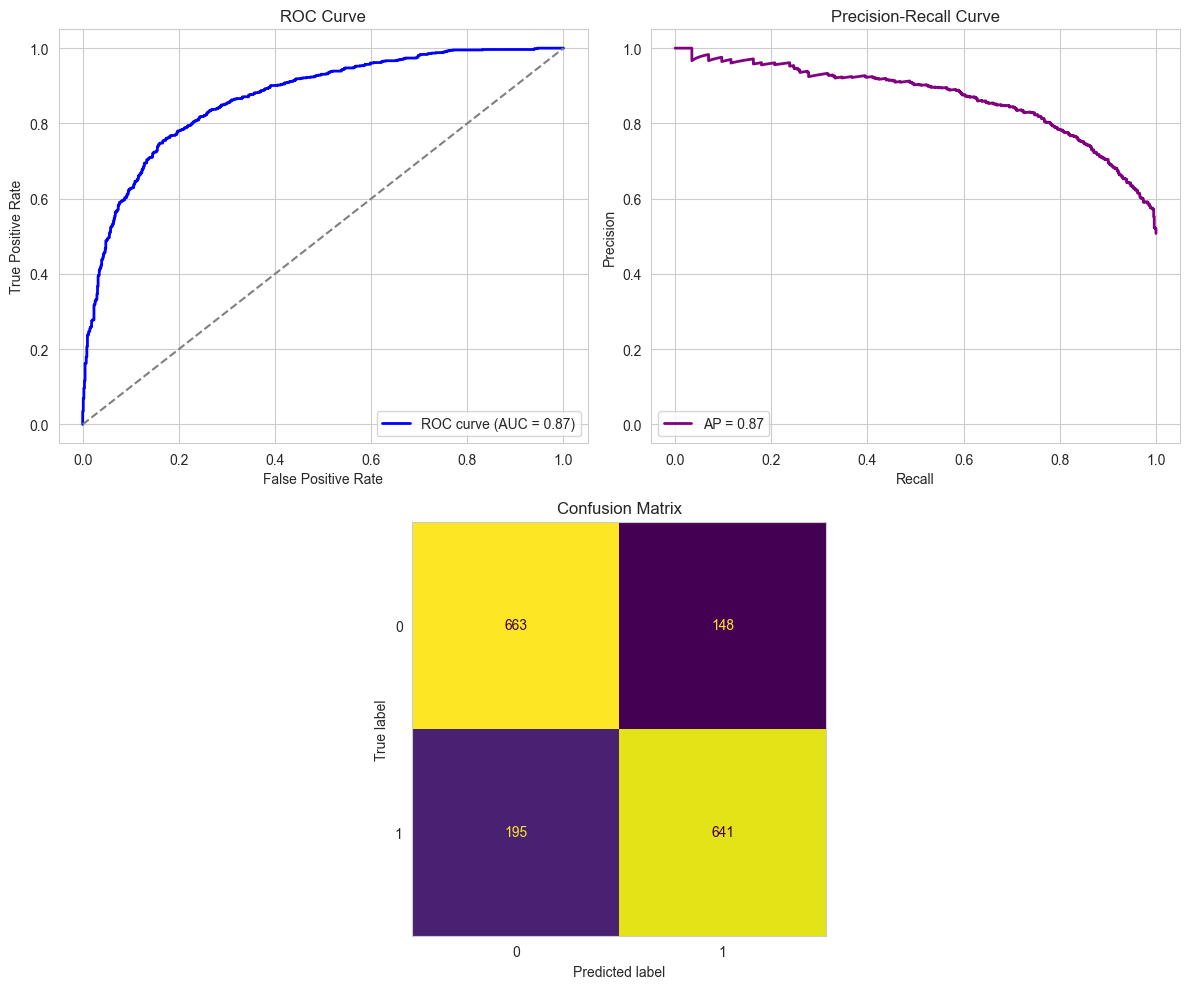


N_PLIES = 80
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       448
           1       0.82      0.85      0.83       423

    accuracy                           0.83       871
   macro avg       0.83      0.83      0.83       871
weighted avg       0.83      0.83      0.83       871

Accuracy: 0.8335246842709529
F1-score: 0.8315911730545877


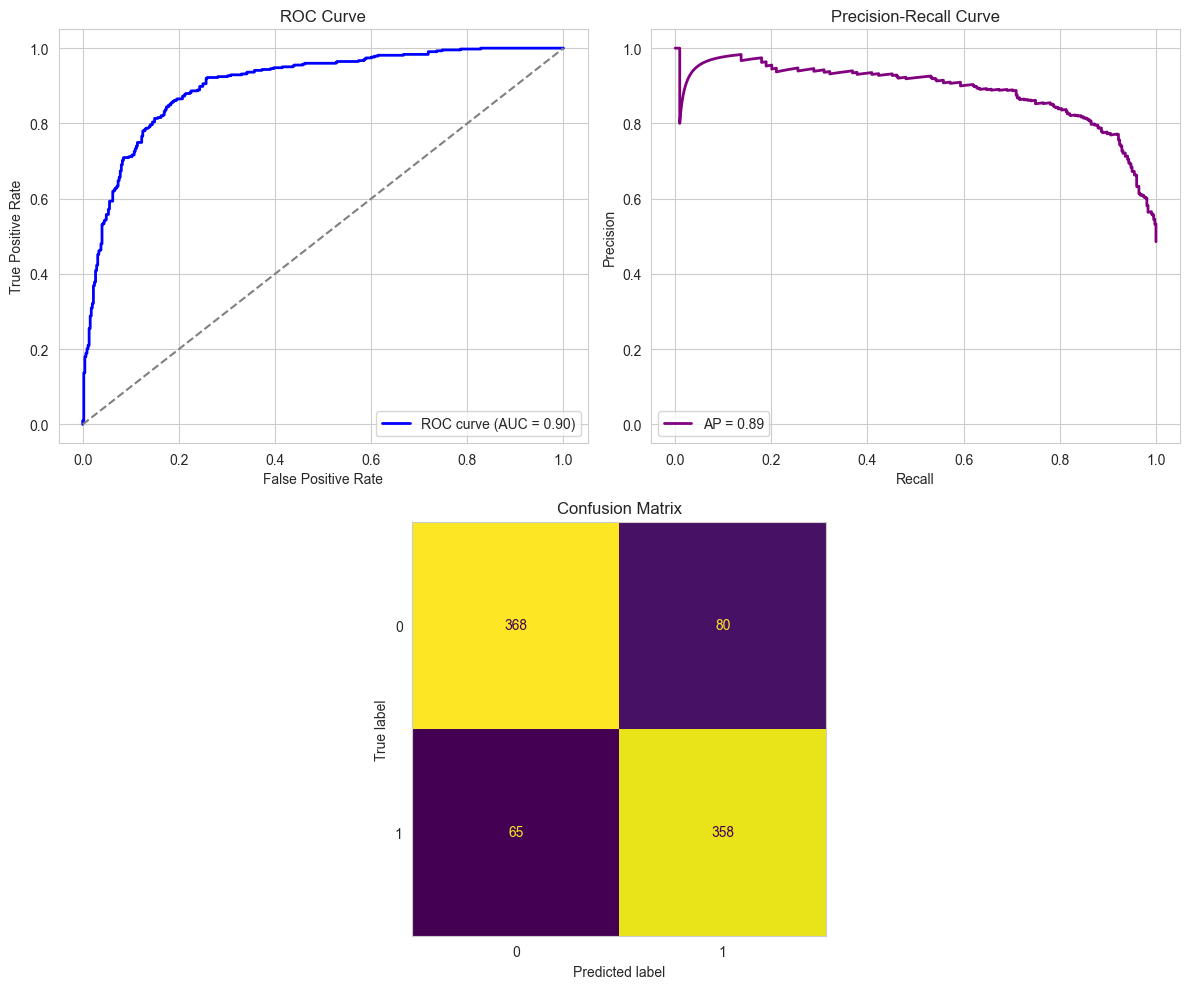


N_PLIES = 100
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       209
           1       0.86      0.81      0.83       234

    accuracy                           0.83       443
   macro avg       0.83      0.83      0.83       443
weighted avg       0.83      0.83      0.83       443

Accuracy: 0.8284424379232506
F1-score: 0.8333333333333334


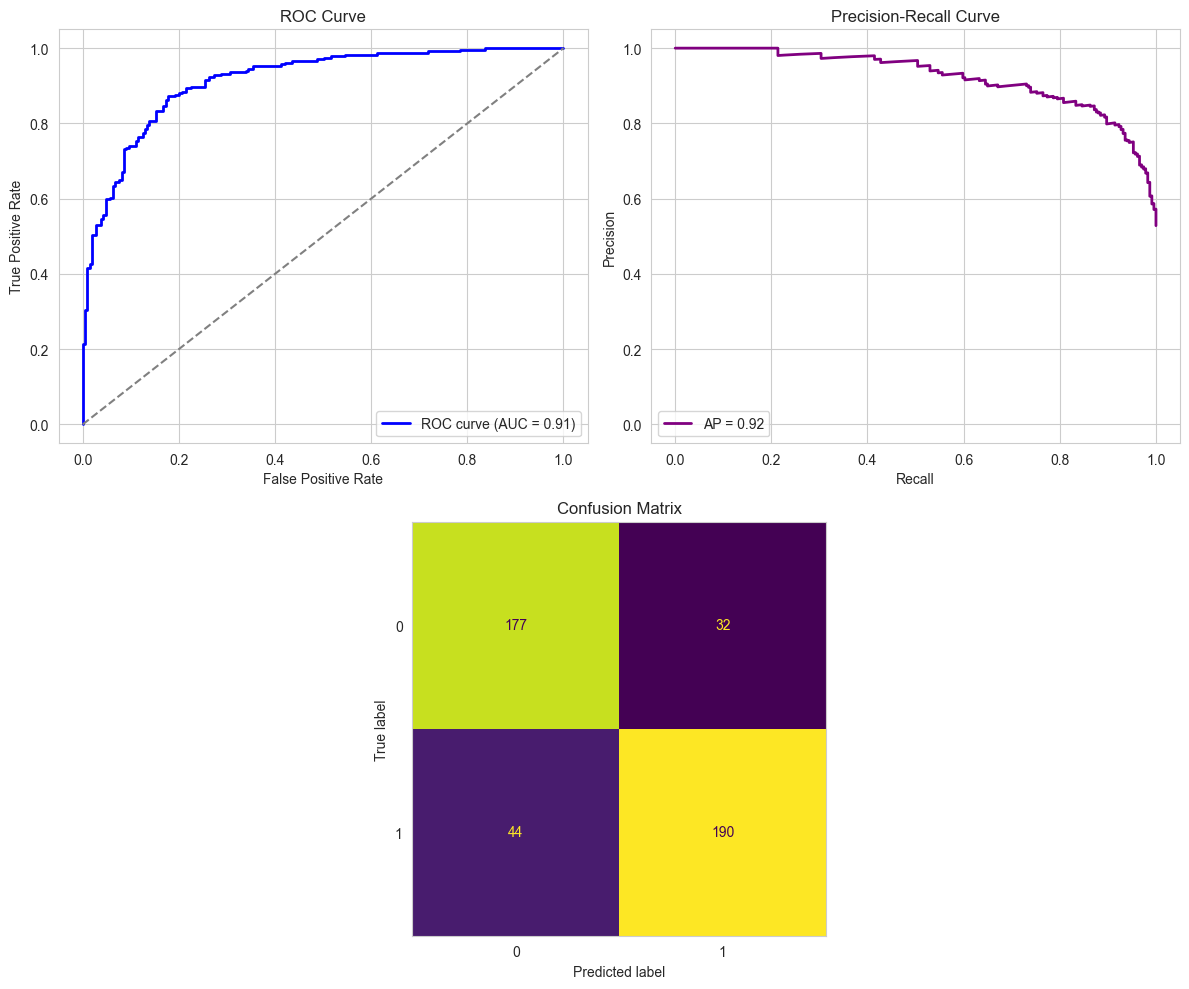


N_PLIES = 110
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       161
           1       0.86      0.83      0.85       145

    accuracy                           0.86       306
   macro avg       0.86      0.86      0.86       306
weighted avg       0.86      0.86      0.86       306

Accuracy: 0.8562091503267973
F1-score: 0.8461538461538461


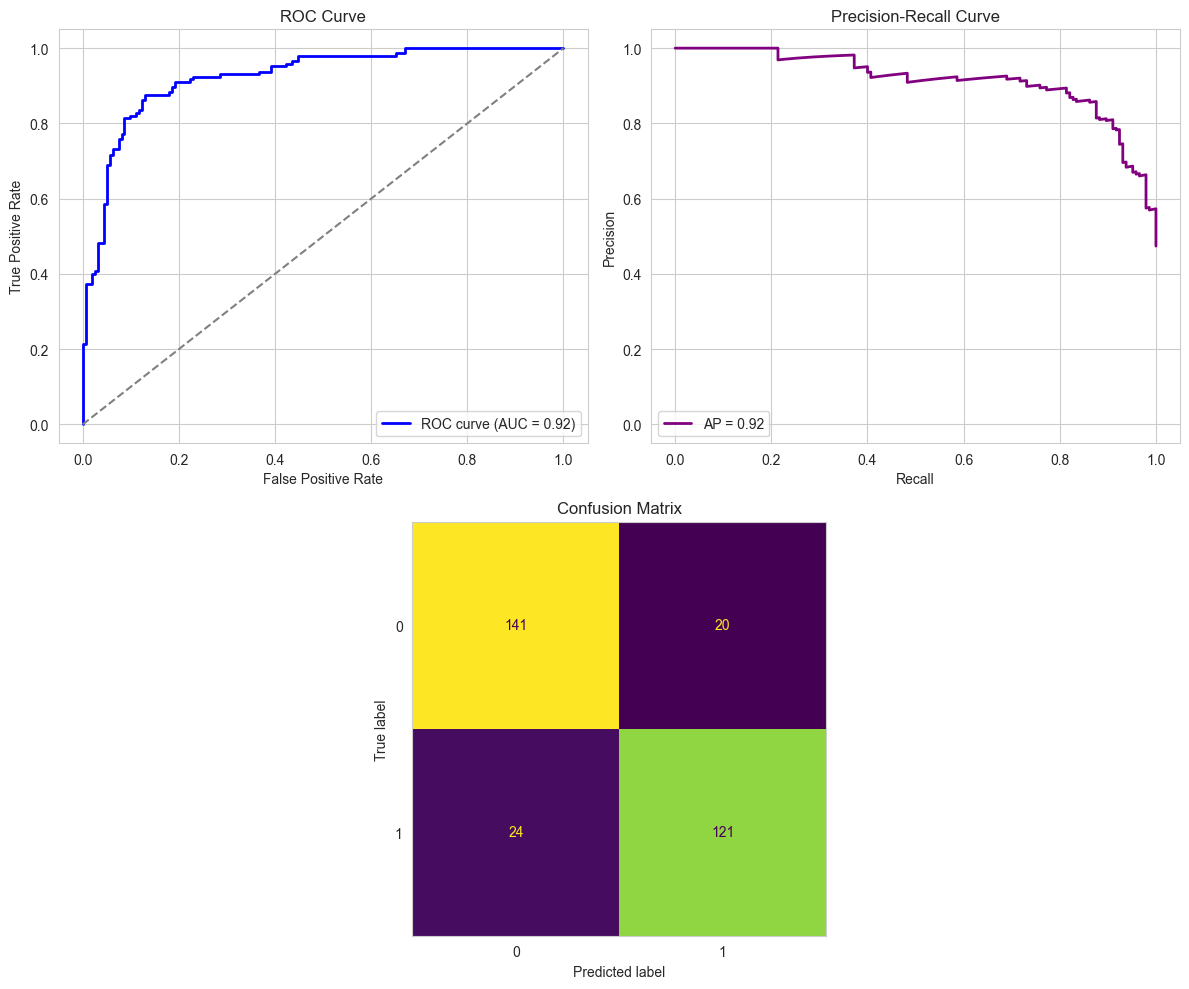


N_PLIES = 120
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        94
           1       0.94      0.88      0.91       100

    accuracy                           0.91       194
   macro avg       0.91      0.91      0.91       194
weighted avg       0.91      0.91      0.91       194

Accuracy: 0.9072164948453608
F1-score: 0.9072164948453608


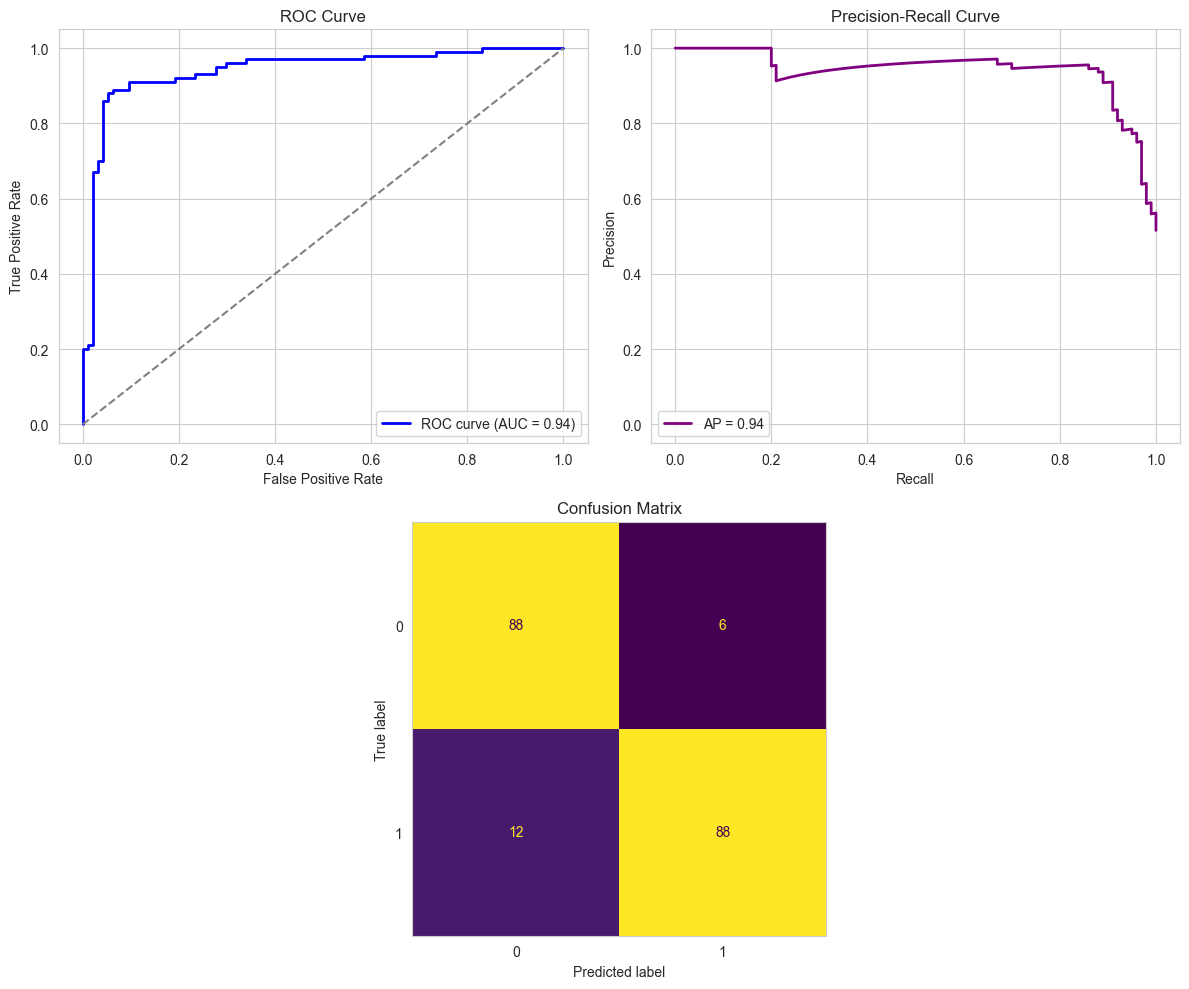


N_PLIES = 150
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        27
           1       0.80      1.00      0.89        20

    accuracy                           0.89        47
   macro avg       0.90      0.91      0.89        47
weighted avg       0.91      0.89      0.89        47

Accuracy: 0.8936170212765957
F1-score: 0.8888888888888888


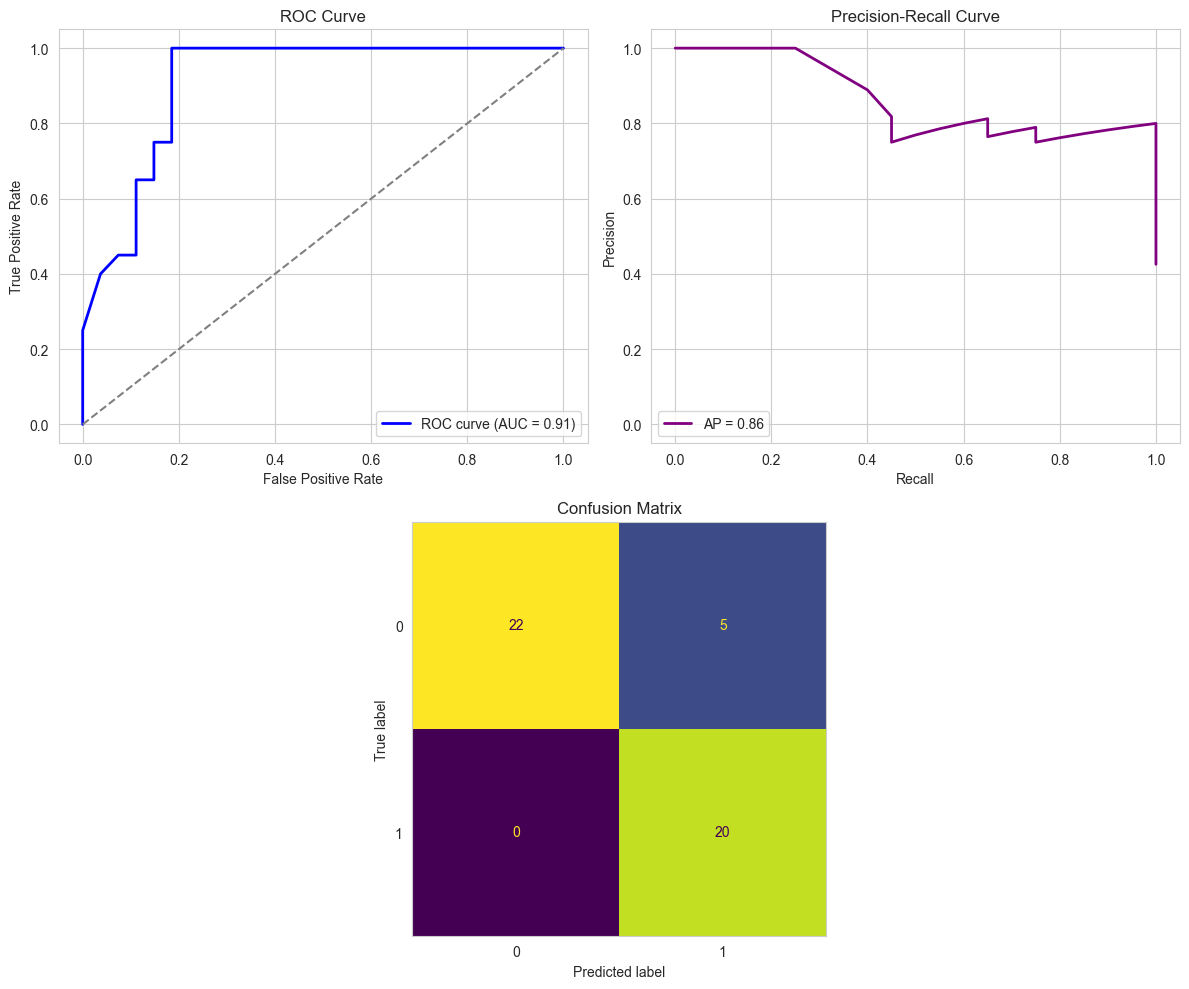


RESULTADOS FINALES:

      N  accuracy  n_partidas
0     4  0.672157       18820
1     8  0.683745       18637
2    16  0.678611       17999
3    20  0.680274       17515
4    30  0.705382       15882
5    40  0.729511       13605
6    60  0.791743        8234
7    80  0.833525        4353
8   100  0.828442        2213
9   110  0.856209        1527
10  120  0.907216         970
11  150  0.893617         231


In [62]:
# lista de N a evaluar
N_list = [4, 8, 16, 20, 30, 40, 60, 80, 100, 110,120, 150]

results = []

for N_PLIES in N_list:
    print("\n==============================")
    print(f"N_PLIES = {N_PLIES}")
    print("==============================")
    df["num_plies"] = df["moves"].apply(count_plies)

    df_filtered = df[df["num_plies"] >= N_PLIES].copy()
    df_filtered.reset_index(drop=True, inplace=True)

    df_filtered = add_move_features(df_filtered, n_moves=N_PLIES)

    explan = [
        'rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate',
        'vs_prev_matches','diff_experience','diff_global_winrate',
        'diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak',
        'white_piece_count','black_piece_count', 'white_material_value', 'black_material_value', 'material_balance',
        'white_center_control', 'black_center_control'
    ]
    target = "winner"

    X = df_filtered[explan]
    y = df_filtered[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5
    )

    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)

    metriques(gb_model, X_test, y_test)
    grafiques(gb_model, X_test, y_test)

    # Guardar resultados
    results.append({
        "N": N_PLIES,
        "accuracy": accuracy_score(y_test, y_pred),
        "n_partidas": len(df_filtered)
    })

# Mostrar tabla final
results_df = pd.DataFrame(results)
print("\nRESULTADOS FINALES:\n")
print(results_df)


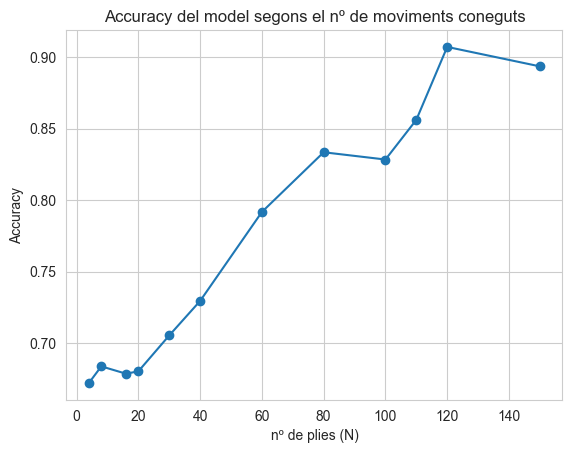

In [63]:
plt.plot(results_df["N"], results_df["accuracy"], marker='o')
plt.xlabel("nº de plies (N)")
plt.ylabel("Accuracy")
plt.title("Accuracy del model segons el nº de moviments coneguts")
plt.show()

COSAS QUE FALTAN POR HACER
- ejecutar todos los modelos con los mejores hiperparametros del crossvalidation
- OPENINGS (no los he usado al añadir los movimientos porque cada opening tiene diferente numero de plies)
- també podem fer un model fins al numero de moviments d'apertura (opening ply).
- probar otros modelos que no sean gradient boosting? igual mejor descartar los demas antes y centrarnos luego en ejecutar solo con gradient boosting (justificando que es el que mejor resultados da) (NOSE MUY BIEN COMO PORQUE NOS DAN MUY PARECIDOS, IGUAL HAY QUE PROBAR OTROS MODELOS AÑADIENDO LOS MOVIMIENTOS PARA VER SI CAMBIA MAS QUE SOLO CON LAS VARIABLES PREVIAS)